In [54]:
'''
hdx_ms_hxexpressformat_analysis v3.0a       LMT         18September2023
Modifying from _GuttmanData_ to read any dataset formatted like HXExpress ouput
*.fasta file within data folder 
            sample   peptide_range  peptide    charge  dataformat
file name: HSPB1_B1B5_0001-0011-MTERRVPFSLL-z2-allspectra.xlsx

file contents, replicates indicated by .001 etc difference in time point header
undeut		        TD		            5 sec		            5.001 sec		        5.002 sec
672.3711	0	    672.3762	0	    672.3644	0	        672.3586	0	        672.3611    0
672.3824	41.1048	672.3875	321.42	672.3757	1515.9935	672.3699	294.3263	672.3725    1132.8987


---
hdx_ms_GuttmanData_analysis v3.0a           LMT         01September2023

the desired output from this script is the relative Deuterium level at each time point as determined from the Centroid and Binomial fits
    and the populations if multiple states are prese sdfsadf

--- ADDING DATA FORMAT TO READ IN (A different version handles complete SpecExport folder heirarchy from HDExaminer) ----
Data from Guttman is formatted for HX-Express excel addon
I added charge and peptide as top two entries and saved as .csv files
data is then m/z vs I columns for each time point, un = undeut, TD = total deut, other times are "<value> <unit>"

charge,      <value>
peptide,     <string>
un (m/z) ,   (I),         time2,   (I),      time3, (I)

-----

Version 3.0 is attempting to fit all fractions for polymodal instead of leaving the final frac to be 1 - sum(fracs)
and adding in a 'bootstrap' method for parameter error calculation. Bootstrap does one round of curve_fit and estimates a stderr
based on the residuals. This error is used to generate y_new = y + (value picked from stderr distribution) X nboot times
the fit values are averaged and the errors in each parameter are determined from the stdev of the nboot values
based on https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i


Version 2.0 has been updated to account for the isotopic contributions from non-exchanging atoms (e.g. 13C, 15N, and beyond)
To do this an existing routine called 'brainpy' has been implemented to calculate the expected UnDeut Envelope
This envelope is then nested into the NHex binomial fits 

see # http://mobiusklein.github.io/brainpy/docs/_build/html/#supporting-objects which is a python rewrite of BRAIN
https://pubs.acs.org/doi/10.1007/s13361-013-0796-5 Baffling Recursive Algorithm for Isotopic distributioN calculations

#!pip install brain-isotopic-distribution
#!pip install pyteomics

The input is a composition dictionary, the script currently handles standard amino acids read from the peptide sequence
PTMs could easily be added by defining their compositions manually (using pyteomics)
#mass.std_aa_comp['p'] = mass.Composition({'H':1,'P':1,'O':3})

''';

In [55]:
import numpy as np, pandas as pd 
import scipy.stats as stats
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
#import matplotlib.colors as mcolors

import os
import sys
from scipy.optimize import curve_fit
#from scipy.special import comb
from math import gamma 
from pyteomics import mass
from brainpy import isotopic_variants
import random
from datetime import datetime
from collections import Counter
from Bio import SeqIO

#!pip install openpyxl

import warnings
warnings.simplefilter (action='ignore', category=FutureWarning)

In [56]:
## Functions to read data in different formats

#safety function in case peptide sequence is bad
def goodseq(seq):
    try: 
        mass.most_probable_isotopic_composition(sequence=seq)
        return True
    except: 
        print(f"Sequence {seq} is not defined")
        #exit()
        return False

def get_hxexpress_meta(hx_file):
    labels = hx_file.split('-')
    metadata = {}
    metadata['file']=hx_file
    metadata['sample'] = str(labels[0]).rsplit('_',1)[0] #split off the peptide start_seq
    start_seq = str(labels[0]).rsplit('_',1)[-1] 
    end_seq = labels[-4] #end sequence is fourth from end, allows for whatever sample name formatting
    metadata['start_seq'] = int(start_seq)
    metadata['end_seq'] = int(end_seq)
    metadata['peptide_range'] = '-'.join([start_seq,end_seq])
    metadata['charge']=float(labels[-2][1:])
    metadata['peptide'] = labels[-3]
    return metadata

def read_hexpress_data(f,keep_raw = False):
    
    raw=[]
    all_raw = pd.DataFrame()
    dfs = pd.DataFrame()
    deutdata = pd.DataFrame()
    peaks=[]

    #for f in file_list:    
    if Test_Data:
        split_name = f.lower().split('_')
        if any('angio' in x for x in split_name):
            sample = 'Angio'
            start_seq = '1' 
            end_seq = '8'
            peptide_range = '-'.join([start_seq,end_seq])
            charge=2.0
            peptide = 'DRVYIHPF'              
        elif any('glufib' in x for x in split_name):
            sample = 'GluFib'
            start_seq = '1' 
            end_seq = '14'
            peptide_range = '-'.join([start_seq,end_seq])
            charge=2.0
            peptide = 'EGVNDNEEGFFSAR' 
        else: 
            print("test dataset not found")
            return
    else:  #HSPB1_B1B5_0001-0011-MTERRVPFSLL-z2-allspectra.xlsx
        labels = f.split('-')
        sample = str(labels[0]).rsplit('_',1)[0] #split off the peptide start_seq
        start_seq = str(labels[0]).rsplit('_',1)[-1] 
        end_seq = labels[-4] #end sequence is fourth from end, allows for whatever sample name formatting
        peptide_range = '-'.join([start_seq,end_seq])
        charge=float(labels[-2][1:])
        peptide = labels[-3]

    file=os.path.join(data_dir, f)
        
    try: timepts = pd.read_excel(file,header=None,nrows=1) #get headers
    except IOError as e:
        print (f"Could not read: {f} check path or if file is open")
        return deutdata
    #print(timepts)
    times =[x for x in timepts.values[0] if str(x) != 'nan']
    # print(times)

    delays = []
    for i,dtime in enumerate(times):
        rep = 1     
        if dtime[0:6] == 'undeut': delay = 0.0 
        elif dtime[0:2] == 'TD': delay = 1e6
        else:
            tp = float(dtime.split(' ')[0].split('.')[0])
            tunit = dtime.split(' ')[-1]
            #print(tp, tunit)
            delay = tp * np.power(60.0,'smh'.find(tunit[0]))
        delays += [delay]
        rep = Counter(delays)[delay]
        
        # #print(i,time)
        raw = pd.read_excel(file,skiprows=1,header=None,usecols=[i*2,i*2+1],names=['mz','Intensity']).dropna()
        peaks = peak_picker( raw, peptide, charge, count_sc=0)
        peaks['time']=delay
        peaks['sample']=sample
        peaks['peptide']=peptide
        peaks['charge']=charge
        peaks['rep']=rep
        peaks['peptide_range']=peptide_range
        if keep_raw:
            raw['time']=delay
            raw['sample']=sample
            raw['peptide']=peptide
            raw['charge']=charge
            raw['rep']=rep
            raw['peptide_range']=peptide_range
            all_raw = pd.concat([all_raw,raw])
        dfs = pd.concat([dfs,peaks],ignore_index=True)

    deutdata = dfs.copy()

    time_points = sorted(set(deutdata.time))
    #n_time_points = len(time_points)

    deutdata['time_idx'] = [ time_points.index(t) for t in deutdata.time ]

    ## read in solution file
    if Test_Data:
        file=os.path.join(data_dir, "bimodal_solutions.txt")
        solution = pd.read_csv(file,delim_whitespace=True,)
        solution = solution.sort_values('time').reset_index()
        all_raw['time_idx'] = [ time_points.index(t) for t in all_raw.time ]
        return deutdata, all_raw, solution
    elif keep_raw: 
        all_raw['time_idx'] = [ time_points.index(t) for t in all_raw.time ]
        return deutdata, all_raw
    else: return deutdata

def get_na_isotope(peptide,charge):
    pepcomp = {}
    na_isotope=[]
    if goodseq(peptide): comp = mass.Composition(peptide) 
    else: comp = {}
    for key in list(comp):
        pepcomp[key] = comp[key]
    pepcomp['H'] = pepcomp['H']-count_amides(peptide,count_sc=0.0)
    #pepcomp = {'H': 53, 'C': 34, 'O': 15, 'N': 7}
    theoretical_isotopic_cluster = isotopic_variants(pepcomp, npeaks=10, charge=charge)

    for ipeak in theoretical_isotopic_cluster:
        na_isotope = np.append(na_isotope, ipeak.intensity) #for now just make continuous list for all peptides
                                                            #won't make sense to do this for full version
    return na_isotope

def count_amides (peptide,count_sc=0.0):
    ex_sc = 0
    proline = peptide[1:].count('P')
    for sidechain in 'STYCDEHW':
        ex_sc += peptide.count(sidechain)
    for sidechain in 'R':
        ex_sc += 2*peptide.count(sidechain)
    for sidechain in 'KQN':
        ex_sc += 2*peptide.count(sidechain)
    n_amides = len(peptide)-proline-1+int(ex_sc*count_sc)
    return n_amides


def peak_picker(data, peptide,charge,resolution=100.0,count_sc=0.0):
    n_amides = count_amides(peptide,count_sc=1.0) #including sidechains for maximum m/z window
    undeut_mz = mass.calculate_mass(sequence=peptide,show_unmodified_termini=True,charge=charge) 
    n_deut = np.arange(n_amides+1)
    pred_mzs = undeut_mz + (n_deut*1.006227)/charge
    mz_mid = pred_mzs.mean()

    threshold = 0.01 * data.Intensity.max() #this should be set to some noise value based on actual data

    peaks = []
    zeroes = 0.0

    for i,pred_mz in enumerate(pred_mzs):
        #mass accuracy is in ppm, so default is 50ppm
        mz_range = pred_mz * (1.0+np.array([-1,1])*resolution/1e6)    
        #sort data in range, grab first entry which is the peak
        focal_data = data.copy()[data.mz.between(*mz_range)]
        focal_data['n_deut'] = i 
        focal_data = focal_data.sort_values('Intensity',ascending=False).reset_index(drop=True)

        if (len(focal_data) > 0):
            intensity = max(focal_data['Intensity'].max() - threshold, 0.0)
            if (intensity == 0.0 and pred_mz > mz_mid): zeroes += 0.5 
        else:
            intensity = 0.0
            if (pred_mz > mz_mid): zeroes += 1
        peak = pd.DataFrame({'mz':[pred_mz],'Intensity':[intensity],'n_deut':[i]})
        peaks.append( peak )
        if zeroes > 4: break

    return pd.concat(peaks,ignore_index=True)

def get_mz_env(value, df, colname='Intensity',pts=False):
    '''
    get mz values at value = envelope_height (e.g. 0.1*maxIntensity)
    to define the envelope width, for assessment of expected polymodal fits
    '''
    df = df.reset_index()
    boolenv = df[colname].gt(value)
    envpts = boolenv.value_counts()[True] # number of points in envelope
    loweridx = df[colname].where(boolenv).first_valid_index()
    upperidx = df[colname].where(boolenv).last_valid_index()
    if df[colname].iloc[0] > value:
        min_mz = df['mz'].iloc[0] #envelope starts with first datapoint
        left_Int = df[colname].iloc[0] 
    else:     
        x1a = df[colname].iloc[loweridx]
        x1b = df[colname].iloc[loweridx-1]
        y1a = df['mz'].iloc[loweridx]
        y1b = df['mz'].iloc[loweridx-1]
        min_mz = y1a + (y1b - y1a) * (value - x1a)/(x1b - x1a)
        left_Int = value
    
    if df[colname].iloc[-1] > value:
        max_mz = df['mz'].iloc[-1] #envelope goes to end of datapoints, poorly picked masspec?
    else:
        x2a = df[colname].iloc[upperidx]
        x2b = df[colname].iloc[upperidx+1]
        y2a = df['mz'].iloc[upperidx]
        y2b = df['mz'].iloc[upperidx+1]
        max_mz = y2a + (y2b - y2a) * (value - x2a)/(x2b - x2a)
    
    if pts: return np.array([min_mz, max_mz]), left_Int
    else: return np.array([min_mz, max_mz])

## Multi-binomial Functions
def nCk_real(n,k):
    #print("n,k:",n,k)
    if n - k + 1 <= 0: return 0.0
    #elif n+k > 50: return 1e10 #this breaks things, would need to handle overflows some other way
    else: return gamma(n+1)/(gamma(k+1)*gamma(n-k+1))

def binom(bins, n, p):
    k = np.arange(bins+1).astype(float)
    nCk = [nCk_real(n,y) for y in k]
    return nCk*np.power(p,k)*np.power(1-p,n-k)

def binom_isotope(bins, n,p):
    bs = binom(bins,n,p)
    newbs=np.zeros(len(bs) + len(Current_Isotope)+1)
    for i in range(len(bs)):
        for j in range(len(Current_Isotope)):     
            newbs[i+j] += bs[i]*Current_Isotope[j]  
    return newbs[0:bins+1]

def n_binomials( bins, *params ): #allfracsversion
    # params takes the form [scaler, n_1, n_2, mu_1, ..., mu_n, frac_1, ..., frac_n] 
    n_curves = int( (len(params)+1) / 3.0 )
    log_scaler = params[0]
    n_array=np.array(params[1:n_curves+1])
    mu_array = np.array( params[n_curves+1:2*n_curves+1] )
    frac_array=[]
    frac_array = np.array( params[ -n_curves: ] )
    frac_array = frac_array/np.sum(frac_array)
    poissons = [ frac * binom( bins,n, mu ) for frac, n, mu in zip( frac_array, n_array, mu_array ) ]
    return np.power( 10.0, log_scaler ) * np.sum( poissons, axis=0, )


def n_binom_isotope( bins, *params ): #allfracsversion
    # params takes the form [ scaler, mu_1, ..., mu_n, frac_1, ..., frac_n] 
    n_curves = int(( len(params) + 1) / 3.0 )
    log_scaler = params[0]
    n_array = np.array( params[1:n_curves+1] )
    mu_array = np.array( params[n_curves+1:2*n_curves+1] )
    frac_array = np.array( params[ -n_curves: ] )
    frac_array = frac_array/np.sum(frac_array)
    poissons = [ frac * binom_isotope( bins, n, mu ) for frac, n, mu in zip( frac_array, n_array, mu_array ) ]
    truncated = np.power( 10.0, log_scaler ) * np.sum( poissons, axis=0, )[0:bins+1]
    return truncated 

def calc_rss( true, pred,yerr_systematic=0.0 ):
    return np.sum( (pred-true)**2 + yerr_systematic**2 )

def get_params(*fit, sort = False, norm = False, unpack = True): 
    # assuming all fracs
    # binom eqs of form: scaler, nex * n_curves, mu * n_curves, frac * n_curves
    # if sort then reorder nex,mu,frac in order of mu*nexs
    # if norm, then fracs will be scaled to sum to 1.0
        # need to be mindful of mixing up corresponding errors when sorting and norming

    num_curves = int((len(fit)-1)/3)

    scaler = fit[0]
    
    nexs = np.array(fit[1:num_curves+1])
    mus = np.array(fit[num_curves+1:num_curves*2+1])
    fracs = np.array(fit[-num_curves:])

    if sort:
        mn = nexs*mus
        use_index = mn.argsort()
        nexs = nexs[use_index]
        mus = mus[use_index]#[::-1]]
        fracs = fracs[use_index]#[::-1]]
    if norm: 
        sumfracs = np.sum(fracs)
        fracs = fracs/sumfracs
    
    if unpack:
        return scaler, nexs, mus, fracs
    else:
        return np.concatenate((np.array([scaler]),nexs,mus,fracs))

def init_params(n_curves,max_n_amides,max_y,seed=None):
    rng=np.random.default_rng(seed=seed)
    random.seed(seed)
    
    log_scaler_guess = 0.0  
    nex_guess = max_n_amides/2.0*random.uniform(0.7,1.0) #was same for all at max/2 in < ver3.0
    nex_low = 0.0 
    sampled = rng.random(n_curves*2) #array for both mus and fracs
    mu_guess =  list(sampled[0:n_curves]) #[0.2, 0.5, 0.1]
    frac_guess = sampled[-n_curves:]#[0.70, 0.25, 0.05] #allfracs
    frac_guess = list(frac_guess/np.sum(frac_guess))
    frac_uppers = [1.0,1.0,1.0]

    initial_estimate = [ log_scaler_guess ] + [ nex_guess ] * n_curves + mu_guess[0:n_curves] + frac_guess[0:n_curves]
    lower_bounds = [ 0.0 ] + [nex_low]* n_curves + [0.0]* n_curves*2 
    upper_bounds = [ np.log10(max_y)+1, ] + [max_n_amides]* n_curves + [ 1.0 ] *n_curves + frac_uppers[0:n_curves]
    bounds = ( lower_bounds, upper_bounds, )

    return initial_estimate, bounds

def fit_bootstrap(p0_boot, bounds, datax, datay, sigma_res=None,yerr_systematic=0.0,nboot=100,
                  ax=None,full=False,yscale=1.0):
    #p0_boot is a list of all p0 initial parameters with nboot entries
    #if ax != None: ax.plot( mz, datay, color = 'cyan', linestyle='solid',label='boot_datay' )
    p0 = p0_boot[0]
    num_curves = int((len(p0)-1)/3)
    
    if sigma_res==None:
        # Fit first time if no residuals
        pfit, perr = curve_fit( n_fitfunc, datax, datay, p0, maxfev=int(1e6), 
                                        bounds = bounds   )

        print("Ran initial bootstrap curve_fit to generate residuals")

        # Get the stdev of the residuals
        residuals = n_fitfunc(datax,*pfit) - datay
        sigma_res = np.std(residuals)
    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # nboot random data sets are generated and fitted
    ps = []
    ps_cov = []
    for i in range(nboot):
        p0 = p0_boot[i]
        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomDelta = [0 if a==0 else b for a,b in zip(datay,randomDelta)] #don't change y if y=0
        randomdataY = datay + randomDelta 
        #if datapoint is zero, leave as zero and don't let value go negative
        randomdataY = np.clip(randomdataY, 0.0, np.inf) 
        if (len(p0) > len(randomdataY)): 
                            print(f"attempting to fit more paramaters than data points in bootstrap")
                            #should be able to exit at this point, haven't updated last fit parameters including p_err
                            break # exit the for n_curves loop
        randomfit, randomcov = curve_fit( n_fitfunc, datax, randomdataY, p0, maxfev=int(1e6), 
                                    bounds = bounds   )
        
        randomfit[0] = np.power( 10.0, randomfit[0] )
        #rfit = randomfit
        rfit = get_params(*randomfit,sort=True,norm=True,unpack=False) #randomfit #
        ps.append(rfit)
        ps_cov.append(randomcov) ## this won't work if ever Sorting

        #ax.plot( mz, randomdataY*yscale, color = 'magenta', linestyle='dashed', )
        if ax != None: 
            # ax.plot( mz, randomdataY, color = 'green', linestyle='dashed', )
            tempr = rfit.copy()
            tempr[0] = np.log10(rfit[0])
            boot_y = n_fitfunc(datax, *tempr) * yscale 
            ax.plot( mz, boot_y, color = 'darkviolet', linestyle='solid', alpha=0.2 )#label='bootstraps',zorder=10)
            s,n,m,f = get_params(*rfit,norm=True,unpack=True)
            for k in range( num_curves ):
                bfit_yk = s * f[k] * fitfunc( datax, n[k], m[k], ) * yscale
                #plot_label = ('pop'+str(k+1)+' = '+format(frac,'.2f')+'\nNex'+str(k+1)+' = '+format(nex,'.1f'))
                ax.plot( mz, bfit_yk, color = 'green', linestyle='dashed',linewidth=3,alpha=0.2)#label=plot_label)


    ps = np.array(ps)
    mean_pfit = np.mean(ps,axis=0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    ps[:,0] = np.log10(ps[:,0])
    err_pfit = Nsigma * np.std(ps,axis=0)

    mean_pfit[0] = np.log10(mean_pfit[0])

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    if full: return ps, ps_cov #return all the bootstrap fits 
    else: return pfit_bootstrap, perr_bootstrap 

Found 3 sample types with 3 total datasets to analyze.
File 1m-3-z1.csv contains no Intensity data at expected m/z values
File Non-D-2-z1.csv contains no Intensity data at expected m/z values

Dataset 1 of 3
Performing fits for L34K 0034-0038: KVVDL z=1
Missing Un or Full Datasets
Using percentage of maxInt for Noise or setNoise if specified
saving figure as  hdx_ms_hxex3_L34K0034-0038binom_isotope_p02_IndFits_bootNoise0p00_02Nov2023


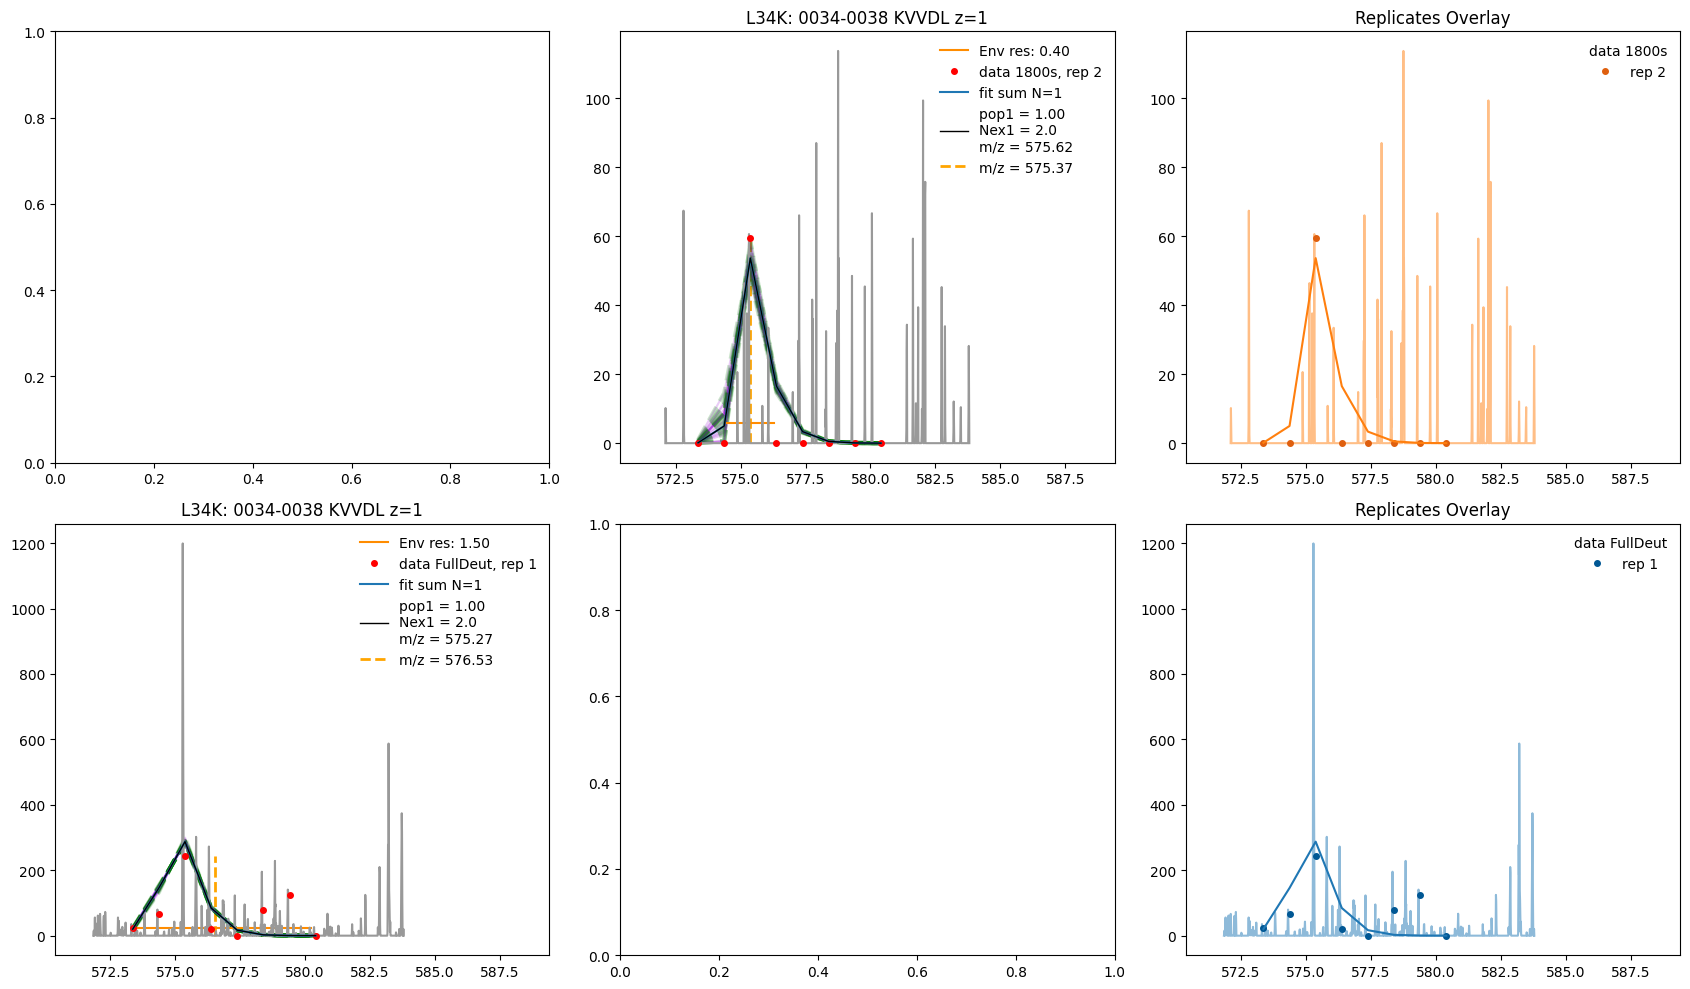

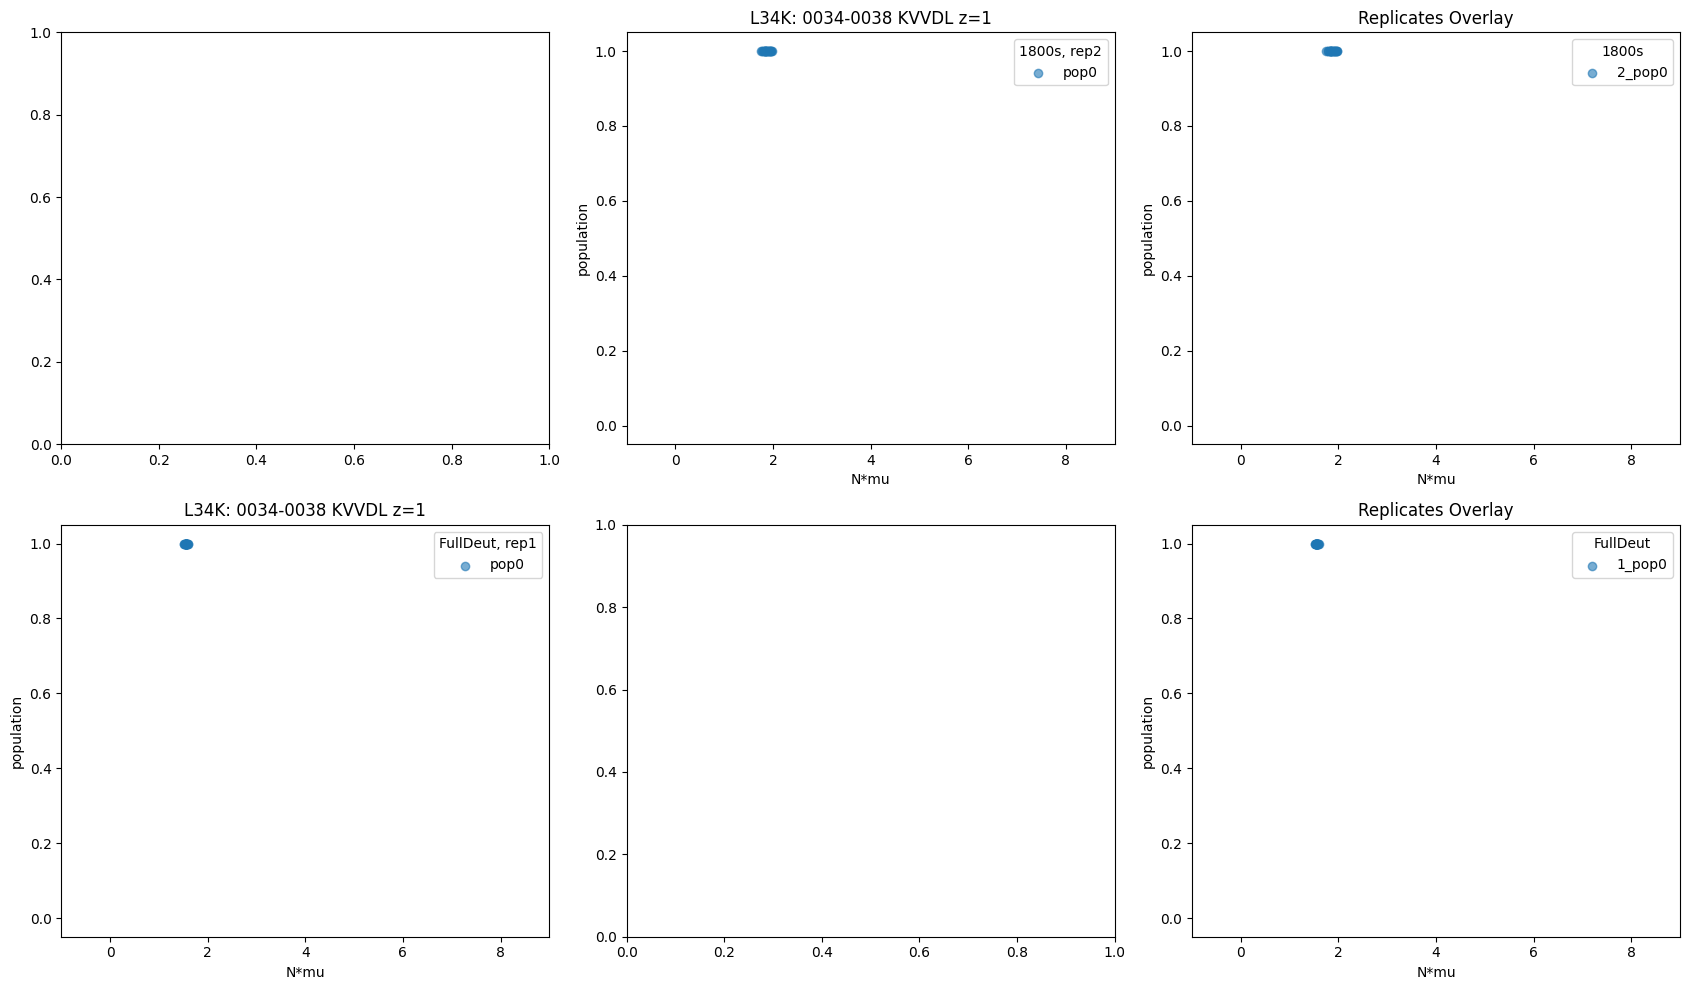

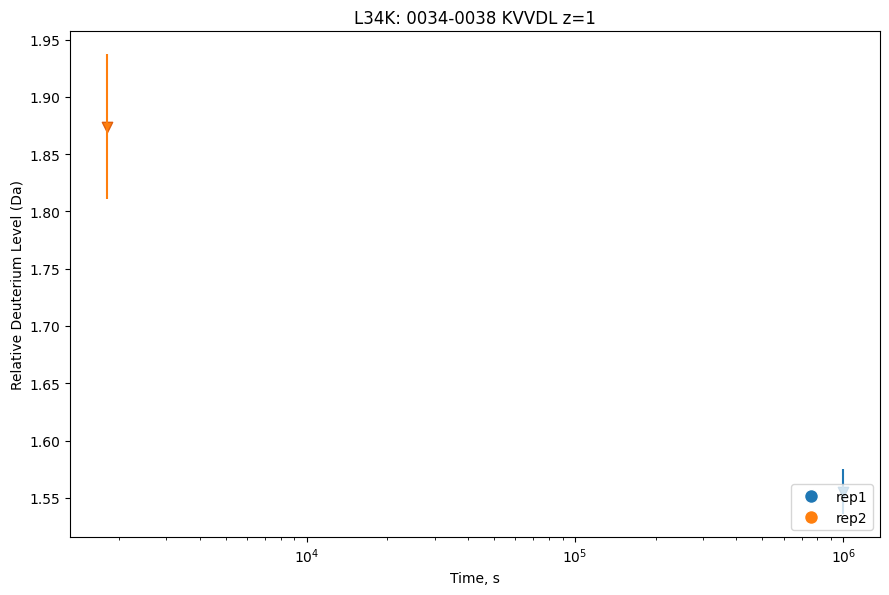

saving figure as  hdx_ms_hxex3_L34K0034-0038binom_isotope_p02_BootFits_bootNoise0p00_02Nov2023
saving figure as  hdx_ms_hxex3_L34K0034-0038binom_isotope_p02_ndeutBoot_bootNoise0p00_02Nov2023

Dataset 2 of 3
Performing fits for WT 0034-0038: LVVDL z=1
attempting to fit more paramaters than data points: time UnDeut rep 1 N=2 curves
attempting to fit more paramaters than data points: time UnDeut rep 2 N=2 curves
attempting to fit more paramaters than data points: time 5s rep 1 N=2 curves
attempting to fit more paramaters than data points: time 5s rep 2 N=2 curves
attempting to fit more paramaters than data points: time 5s rep 3 N=2 curves
attempting to fit more paramaters than data points: time 60s rep 1 N=2 curves
attempting to fit more paramaters than data points: time 60s rep 2 N=2 curves
attempting to fit more paramaters than data points: time 60s rep 3 N=2 curves
attempting to fit more paramaters than data points: time 1800s rep 1 N=2 curves
attempting to fit more paramaters than dat

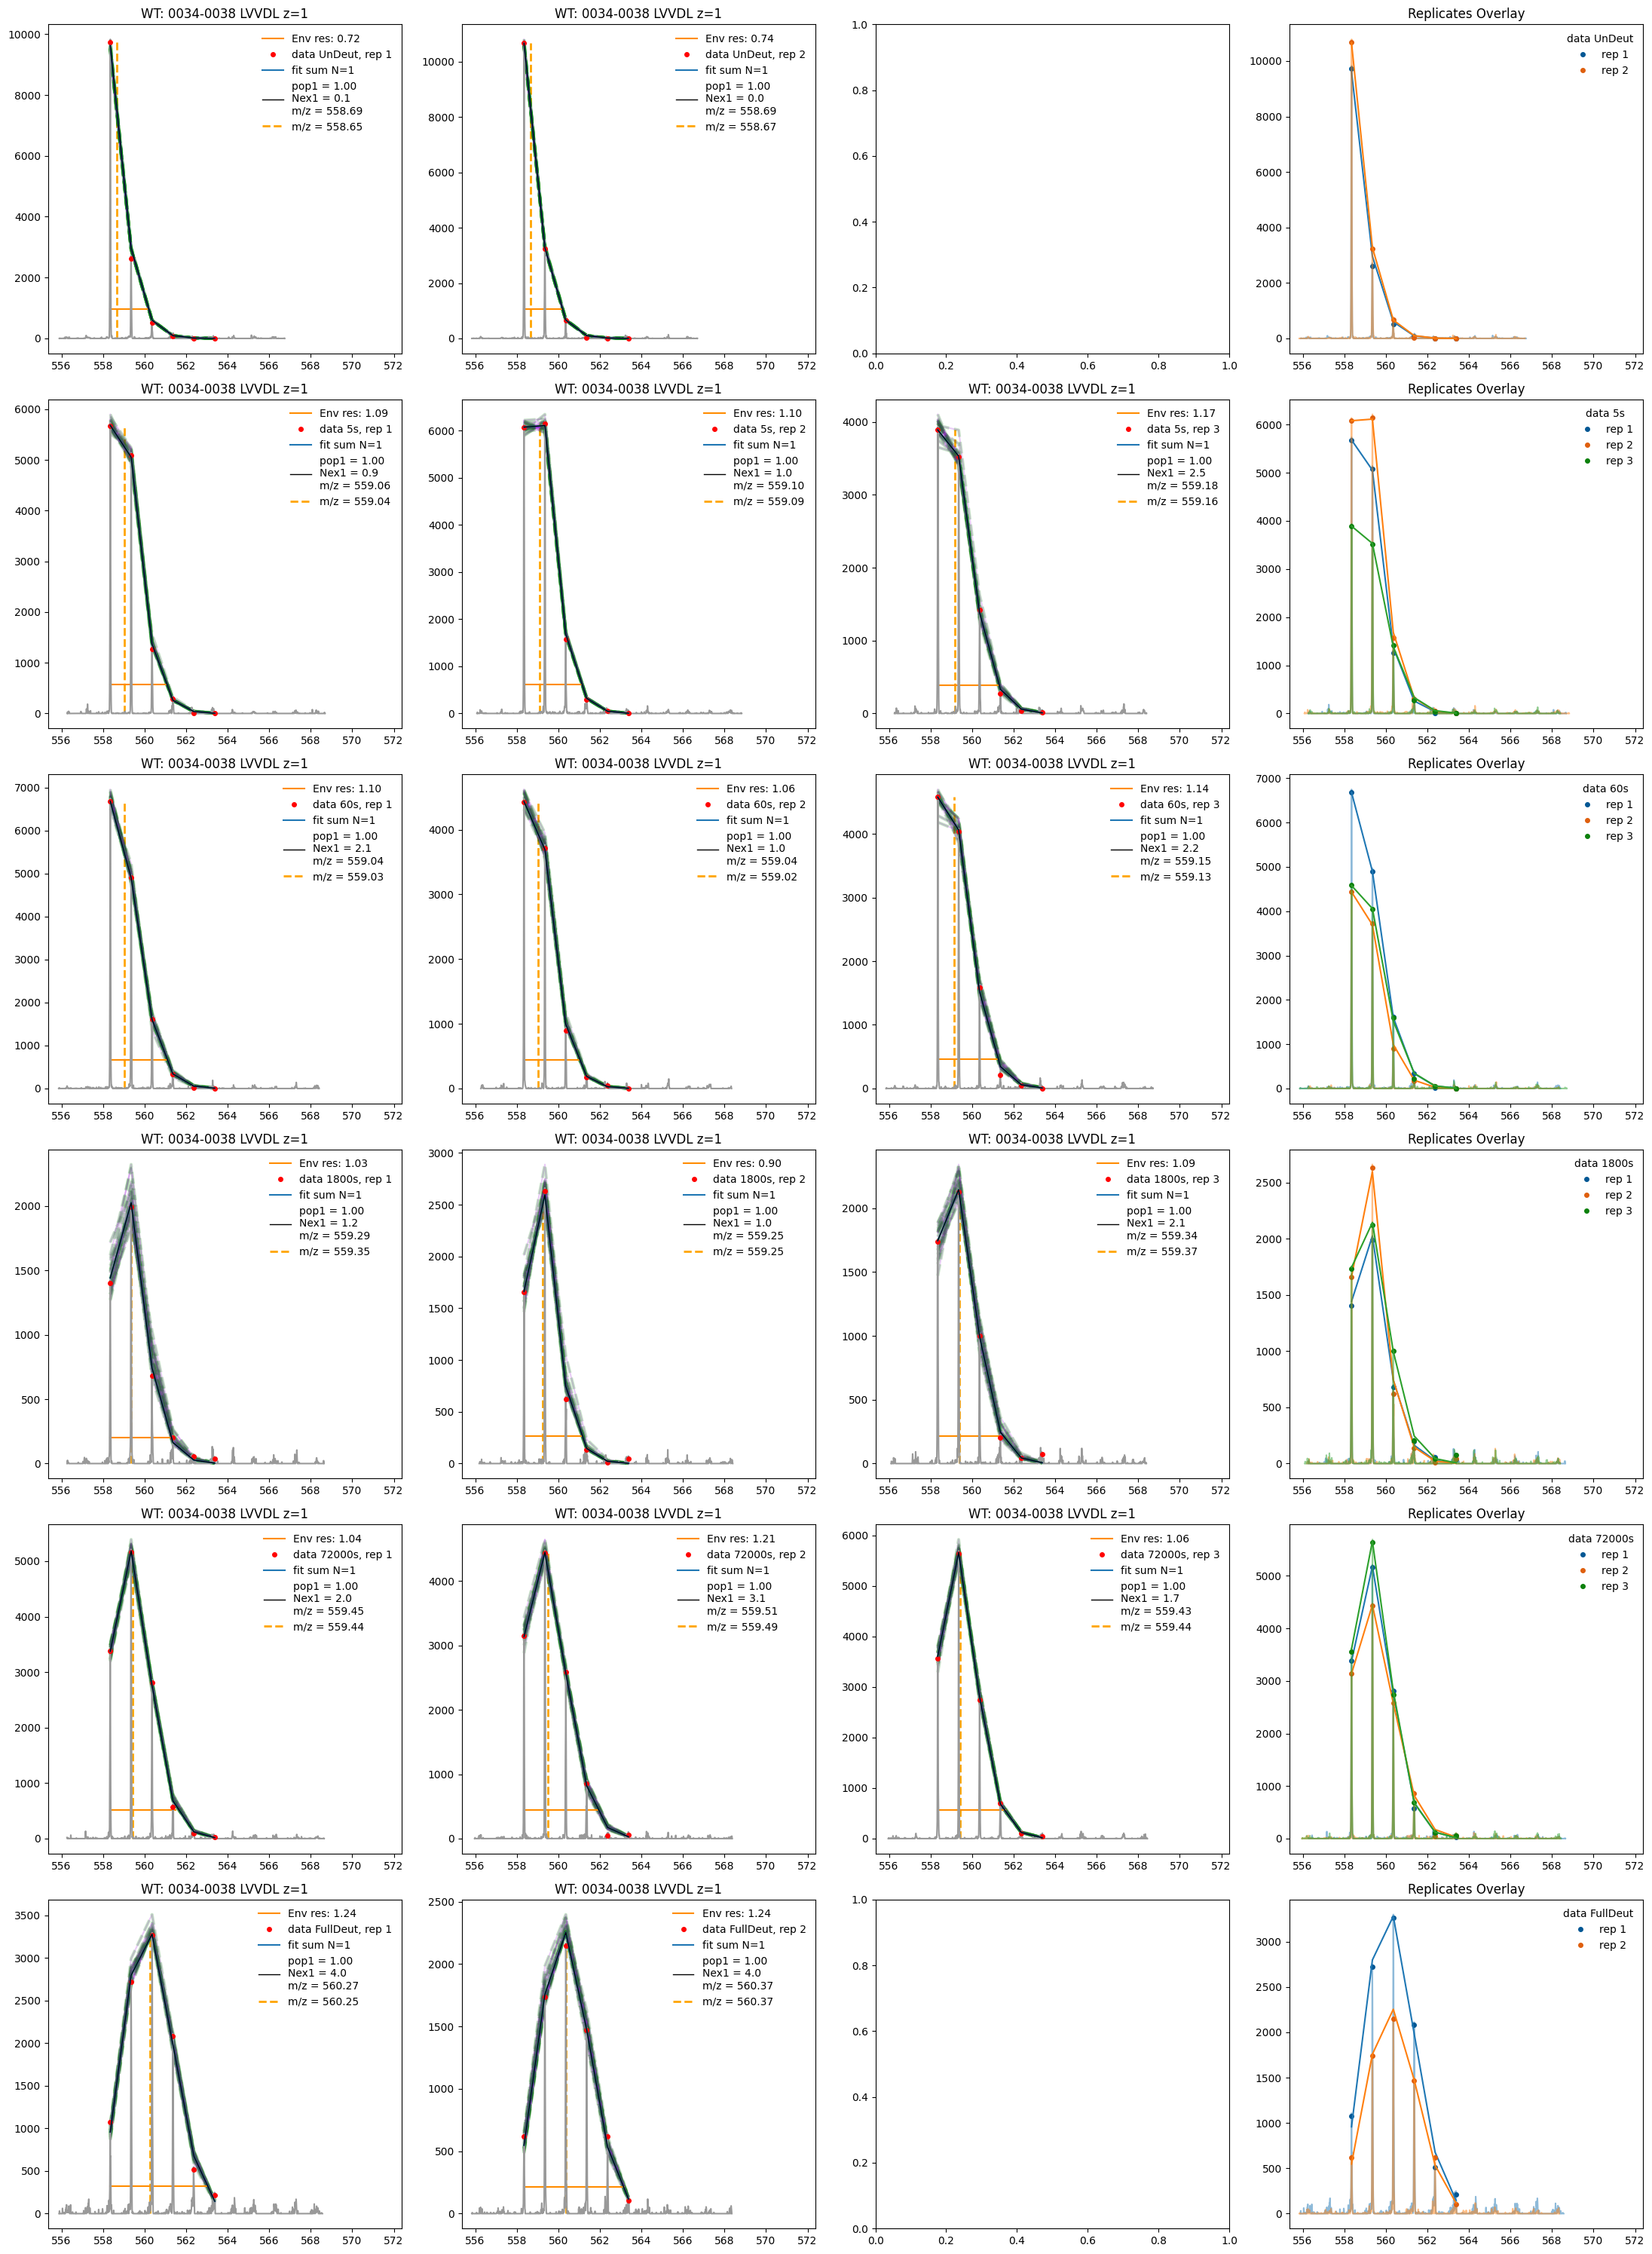

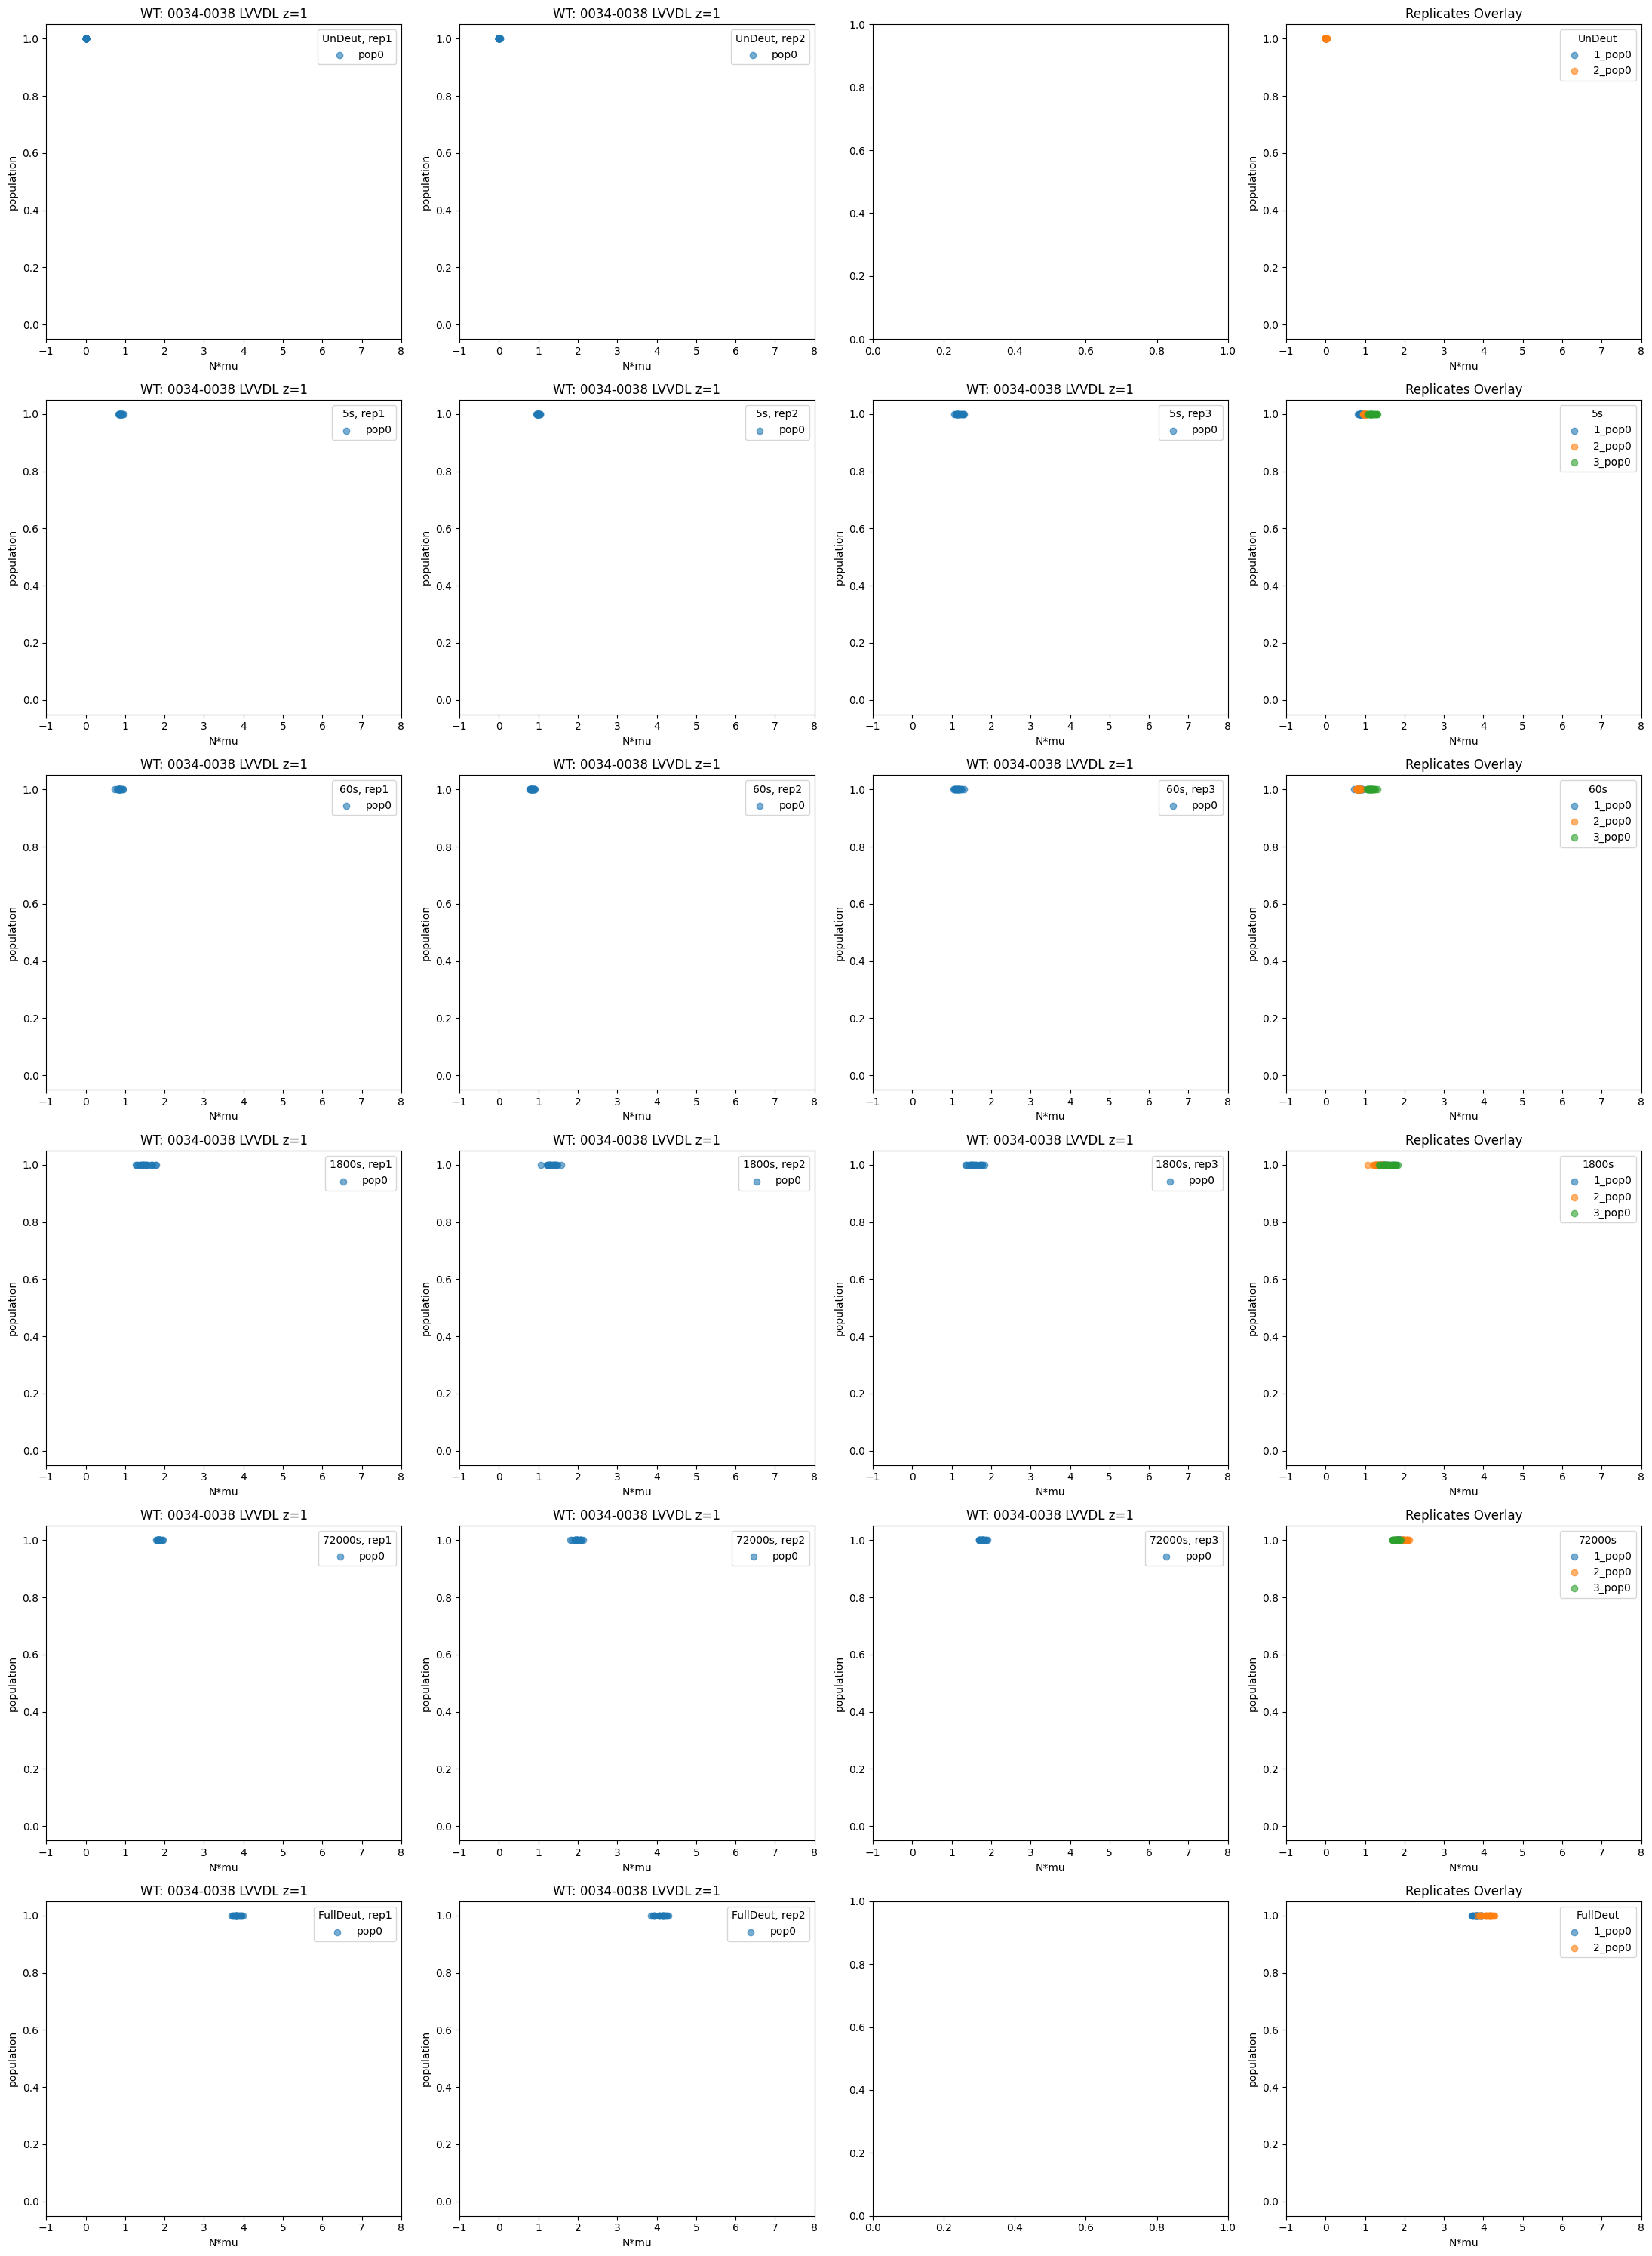

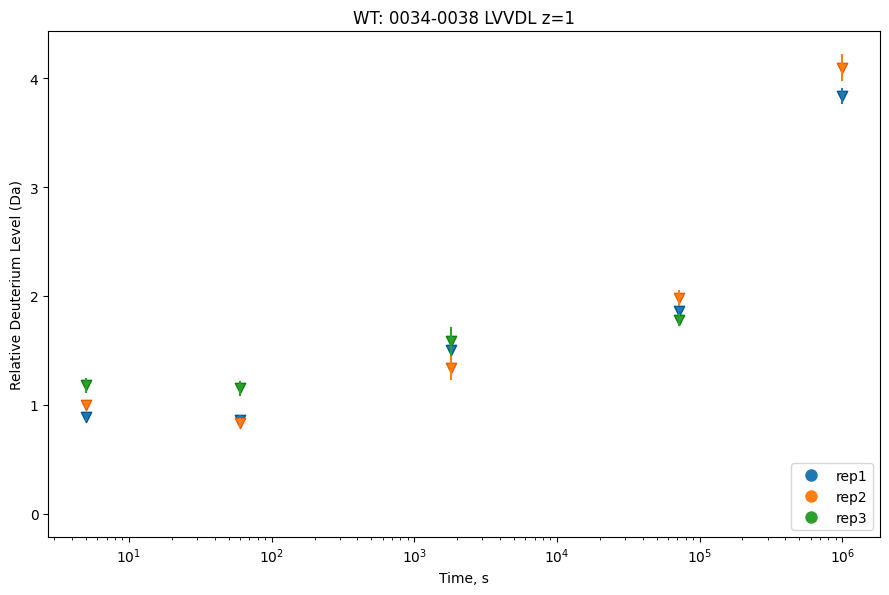

saving figure as  hdx_ms_hxex3_WT0034-0038binom_isotope_p02_BootFits_bootNoise0p00_02Nov2023
saving figure as  hdx_ms_hxex3_WT0034-0038binom_isotope_p02_ndeutBoot_bootNoise0p00_02Nov2023

Dataset 3 of 3
Performing fits for WTmannose 0034-0038: LVVDL z=1
attempting to fit more paramaters than data points: time UnDeut rep 1 N=2 curves
attempting to fit more paramaters than data points: time UnDeut rep 2 N=2 curves
attempting to fit more paramaters than data points: time 5s rep 1 N=2 curves
attempting to fit more paramaters than data points: time 5s rep 2 N=2 curves
attempting to fit more paramaters than data points: time 5s rep 3 N=2 curves
attempting to fit more paramaters than data points: time 60s rep 1 N=2 curves
attempting to fit more paramaters than data points: time 60s rep 2 N=2 curves
attempting to fit more paramaters than data points: time 60s rep 3 N=2 curves
attempting to fit more paramaters than data points: time 1800s rep 1 N=2 curves
attempting to fit more paramaters than 

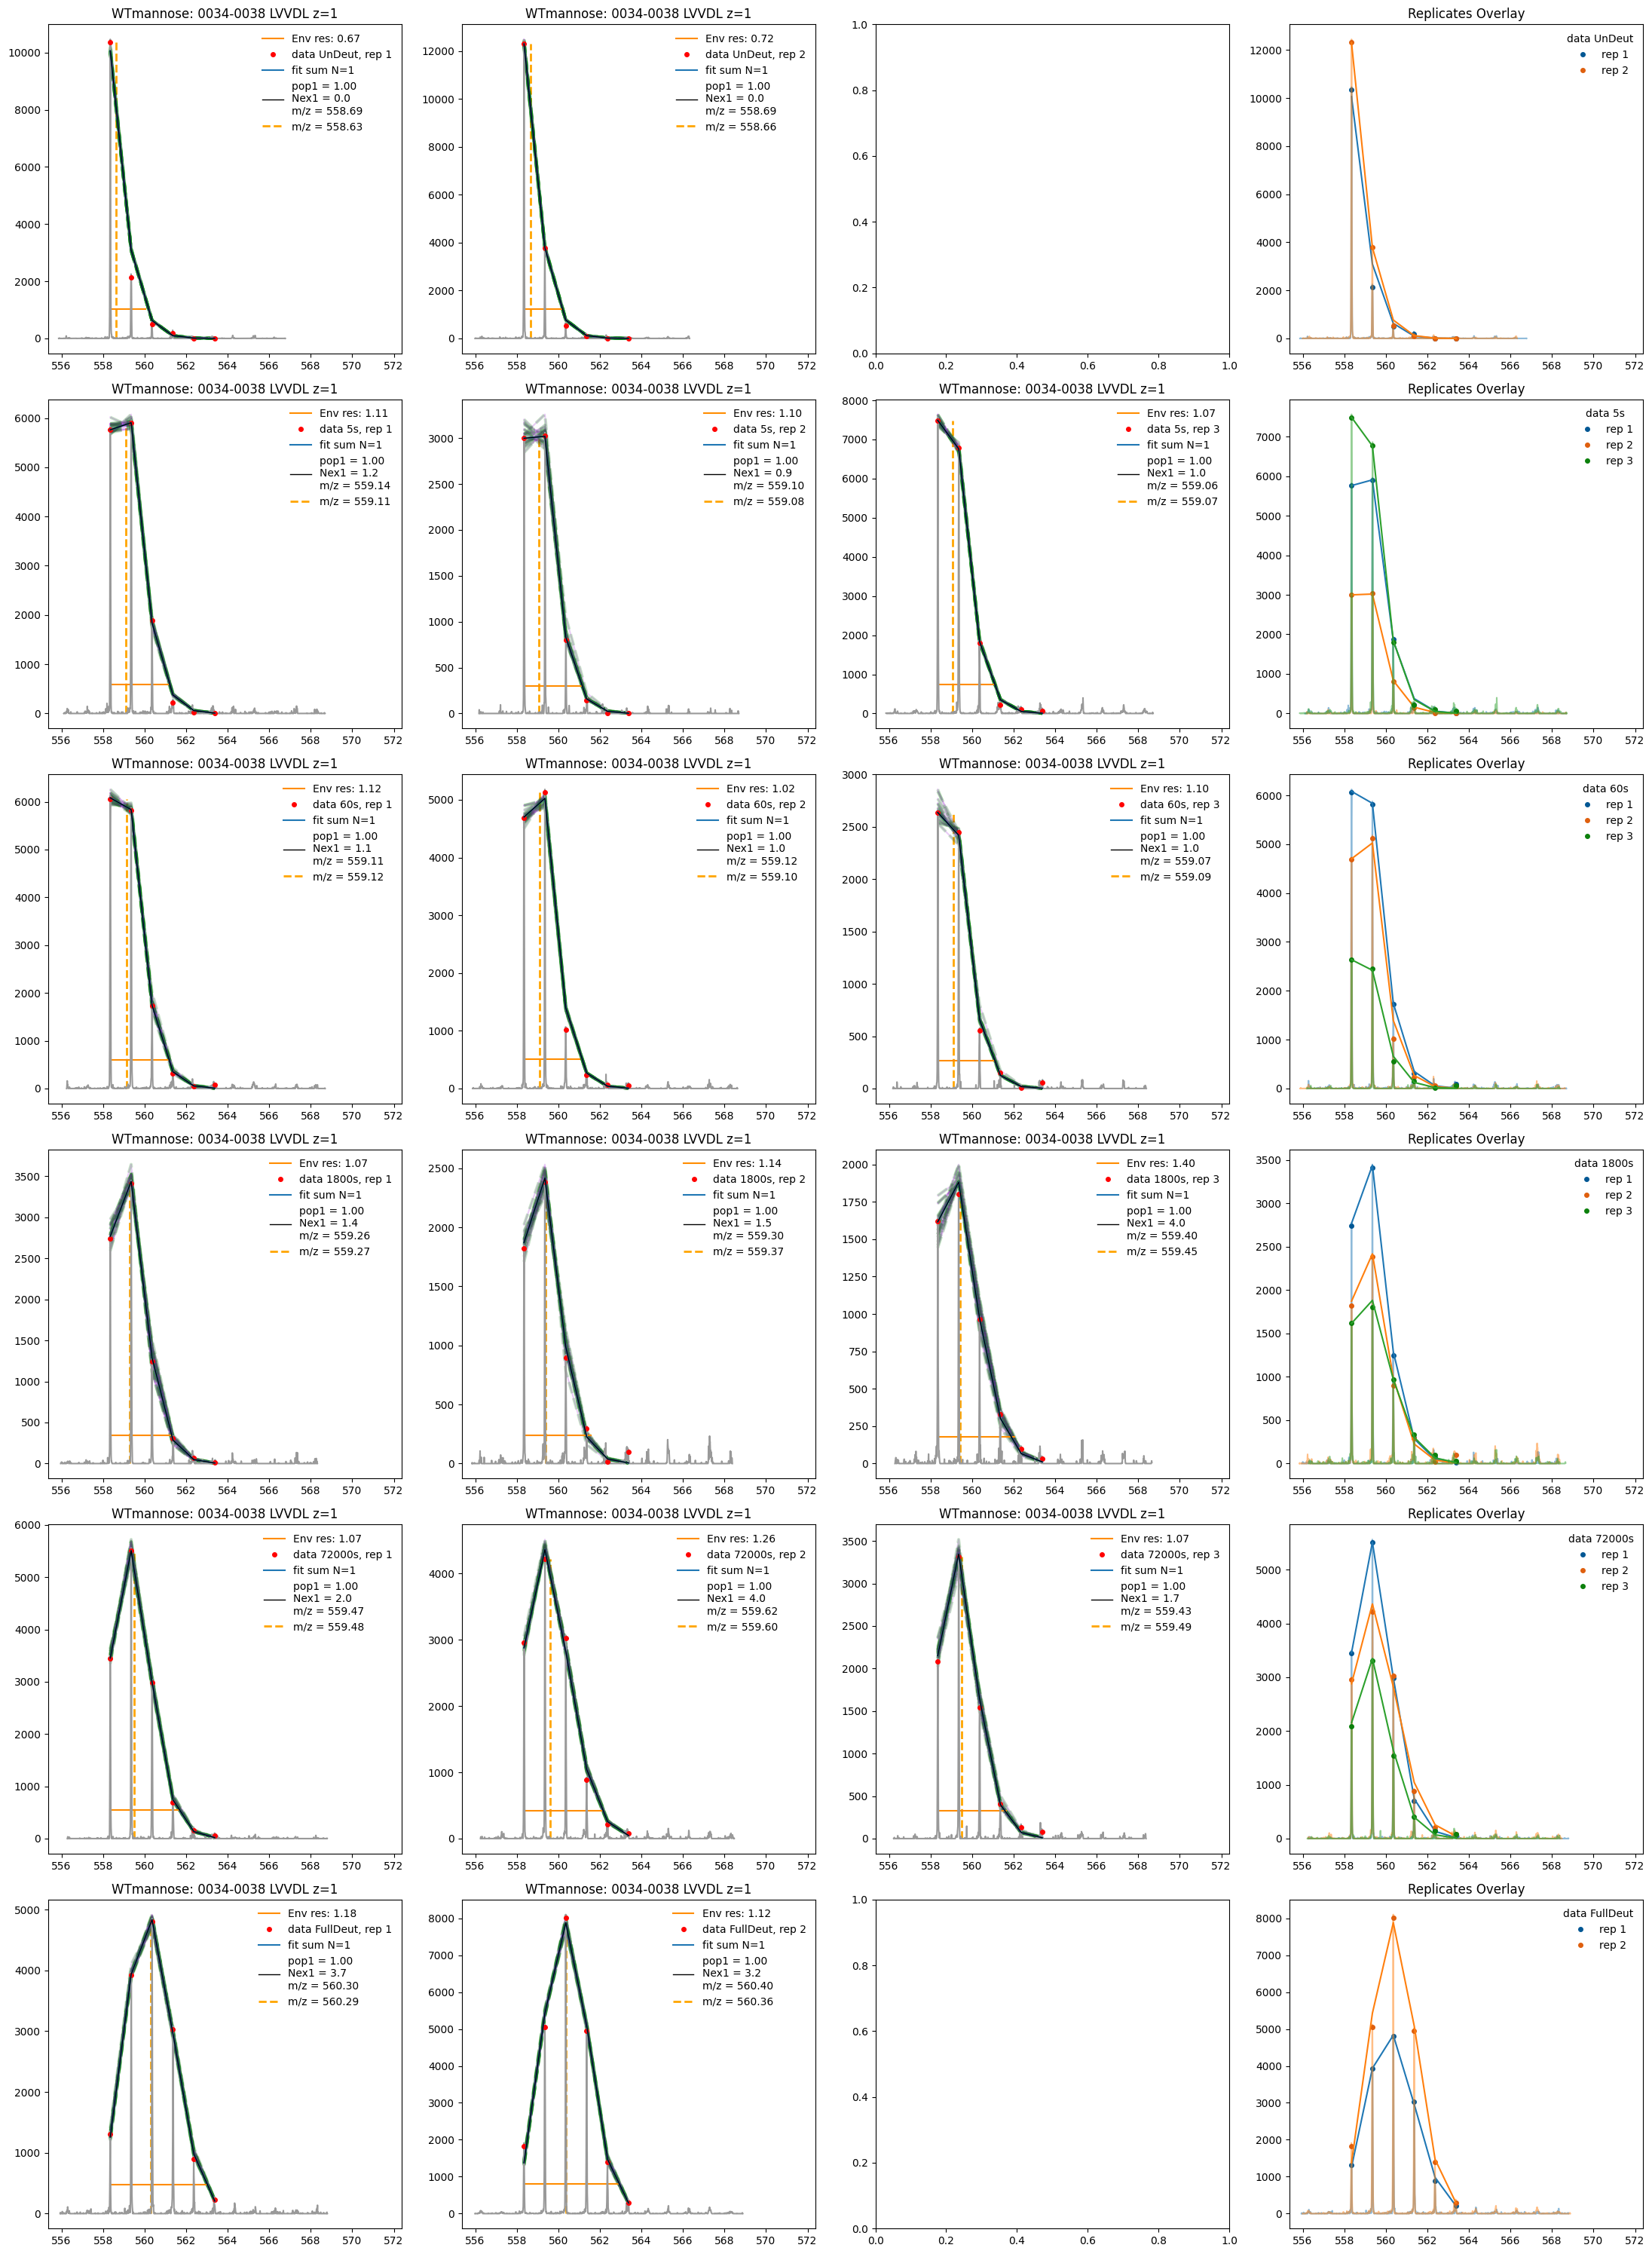

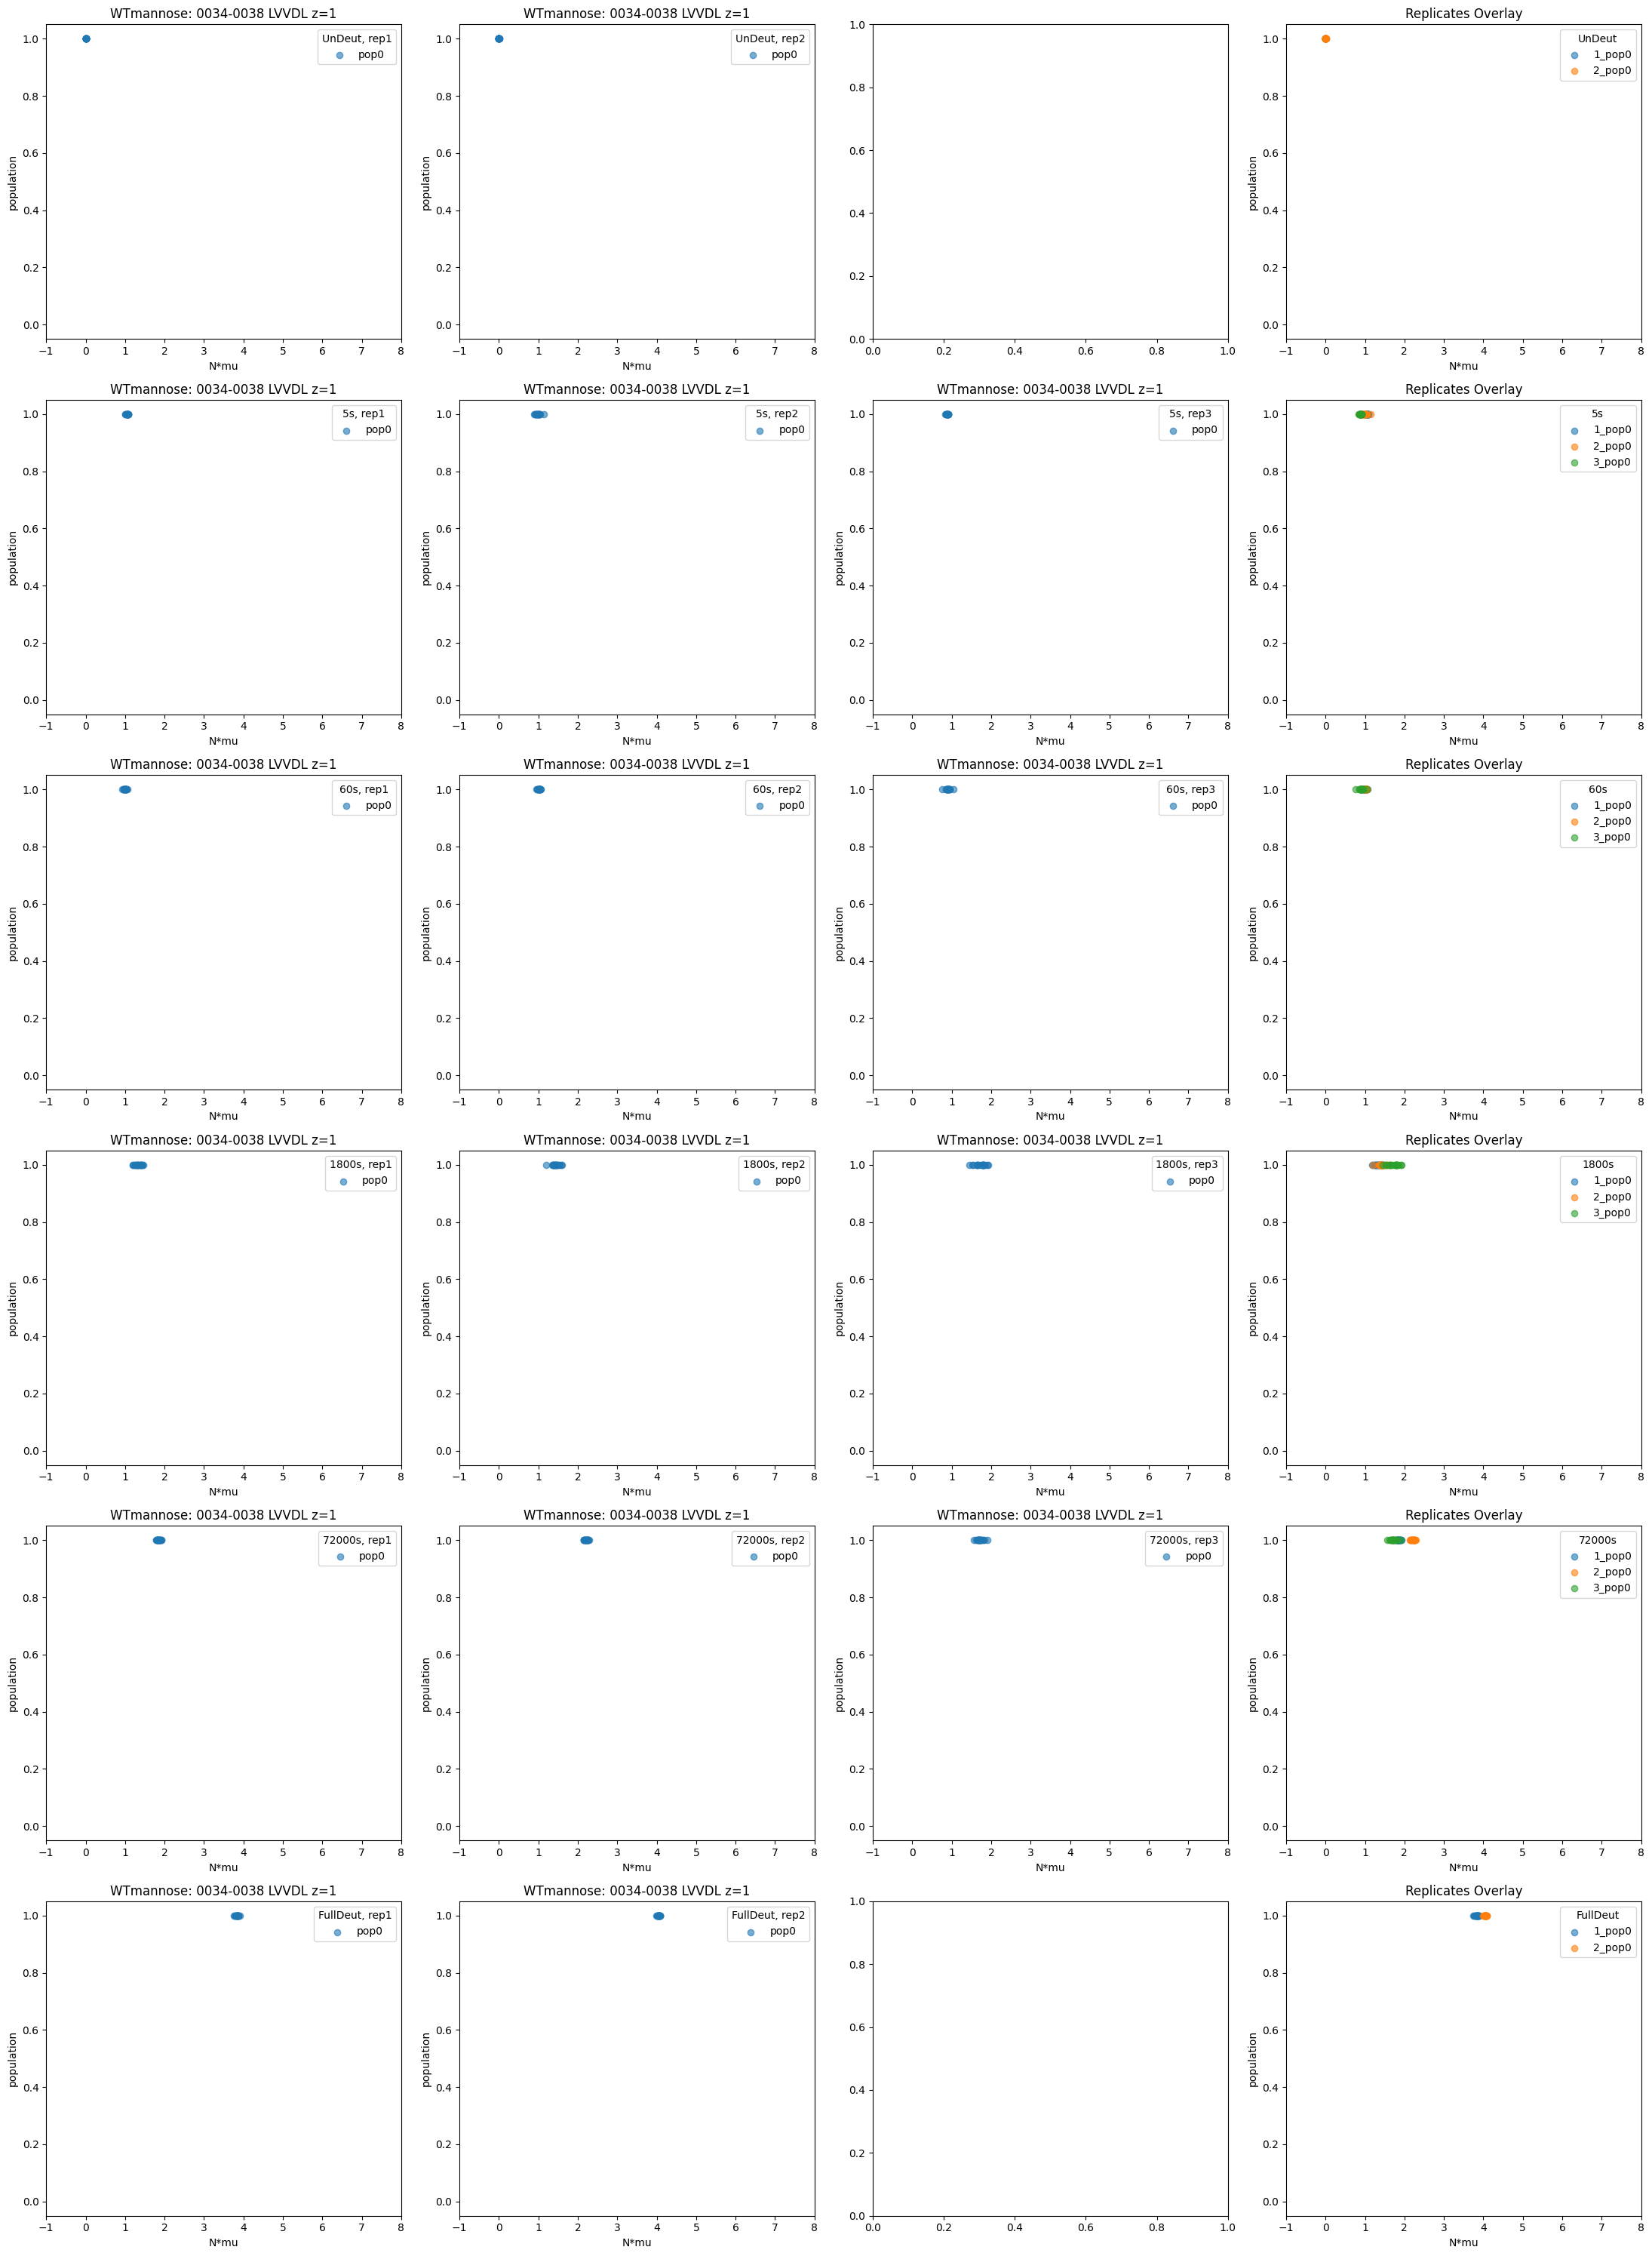

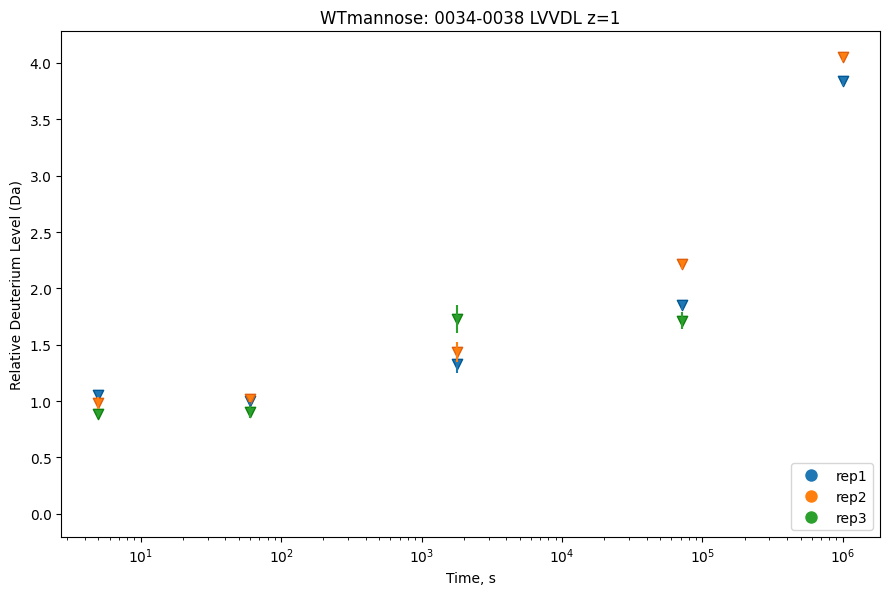

saving figure as  hdx_ms_hxex3_WTmannose0034-0038binom_isotope_p02_BootFits_bootNoise0p00_02Nov2023
saving figure as  hdx_ms_hxex3_WTmannose0034-0038binom_isotope_p02_ndeutBoot_bootNoise0p00_02Nov2023


In [58]:
## RUN IT 
######################
'''begin user input'''
######################

Data_Type = 2  
    #1: 'xlxs' , each file contains all timepoint reps at data_dir/onesample_onepeptide_alltimepts_allreps_onecharge.xlsx
                # current recognized format is e.g. HSPB1_B1B5_0001-0011-MTERRVPFSLL-z2-allspectra.xlsx
                # <sample name>_<peptide start>-<peptide end>-<peptide>-<zcharge>-<unused label>.xlsx
                # allows for replicats of UnDeut/TD even though HX-Express xlsm does not
    #2: 'SpecExport', as exported from HDExaminer data_dir/samples/peptides/onetimept_onerep_onecharge.csv
                # this mode requires a sample.fasta file in the data_dir for each sample to be processed, with matching names

#user_ settings only used if process_ALL = False
#first element can be 'all' to include all mutants and/or peptides in directory
if Data_Type == 1:
    data_dir = 'c:\\Users\\tuttl\\OneDrive\\Documents\\My Documents\\KlevitHahn\\hdx-ms\\ns_HSPB1_Bimodal_Peptide_Data'
    process_ALL = False # if True will assume all .xlsx files are HDX data, use with care
    user_mutants = ['HSPB1only',]#'HSPB1_B1B6'] #['all']
    user_peptides = ['0001-0011',]#'0078-0094']
if Data_Type == 2:
    #data_dir = '/data/tuttle/HDX-MS/Pearl_SpecExport_30oct2023/SpecExport'
    data_dir = 'c:\\Users\\tuttl\\OneDrive\\Documents\\My Documents\\KlevitHahn\\hdx-ms\\ns_HSPB1_Bimodal_Peptide_Data\\SpecExport'
    process_ALL = False #process_all = True is limited to existing .fasta files, this setting overrides user_ settings
    user_mutants = ['all','WTmannose']#,'B1B6','HSPB1'] #['WT','S19D','S45D','S59D','D3']#['All'] #
    user_peptides =  [ '0034-0038',]#'0049-0054']#['0034-0045'] #['0093-0116'] #['0090-0113']'0122-0166']#

Test_Data = False
if Test_Data: 
    Data_Type = 1
    #data_dir = 'c:\\Users\\tuttl\\OneDrive\\Documents\\My Documents\\KlevitHahn\\hdx-ms\\HX-Express3'
    data_dir = 'C:\\Users\\tuttl\\OneDrive\\Documents\\My Documents\\KlevitHahn\\hdx-ms\\pyHXExpress\\Bimodal_HDX_Data'
    #Test_Sets = ['v3_Angiotensin_Bimodals.xlsx','v3_GluFib_Bimodals.xlsx']
    Test_Sets = ['all']

hide_figure_output = False
svg = False # also save figures as an svg file, slow, but better for making figures 

bootstrap = True #False #
full=True #plot all the bootstrap fits, frac vs nex*mu

nboot = 20 # number of individual fits to perform, using n_best_curves from initial round of fits
setNoise = False #if noise value is known, specify instead of estimating as y_err % of avg Un+TD peaks
y_err = 1.0 #Percent random error applied during boot as y*+np.random.normal(0,yerr), 0.0 for NoNoise, ~0.5% for noise added
            # the absolute Noise value is then y_err * avg(maxInt of Un and TD)
            # this is a very rough way to give a consistent Noise value throughout a dataset. 

Env_threshold = 0.1 #find envelope width at Env_threshold * Intensity_max
limit_by_envelope = False # only fit up to n = int(z*env/3*env_limit - 2/3) 
env_limit = 1.0 #used if limit_by_envelope = True, rough measure to constrain n_curves fit according to data width & num fit params
Max_Pops = 2 #maximum number of underlying populations to fit
pop_thresh = 0.03 #fall back to n-1 curves if population is below this, does not apply to bootstrap fits, but does exclude from boot average values
ncurve_p_accept = 0.02 #stringency for accepting more fit populations      
random_seed = 16 #used for parameter initialization
boot_seed = True #if False, same seed as random_seed, 
                 #otherwise different seed for each boot iteration (0 to nboot + random_seed + 1 to not repeat initial fit)   
Scale_Y_Values = True # if Scale_Y_Values = True, plots will be in original Intensity units
                # fit will always be on normalized Intensity as it is much faster               
Keep_Raw = True # peak_picking will retain the Raw spectrum if True, if False will only keep peaks, auto True for Test_Data
Overlay_reps = True #add column to figures that is overlay of all available replicates

####################
'''end user input''';
####################


mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mpl_colors_dark = ['#005794', '#df5f0e', '#0c800c', '#b60708', '#74479d', '#6c362b', '#b357a2', '#5f5f5f', '#9c9d02', '#079eaf']
mpl_colors_light = ['#2f97e4', '#ff9f2e', '#4cc04c', '#f64748', '#b487ed', '#ac766b', '#f397e2', '#9f9f9f', '#dcdd42', '#37deef']
mpl_colors_light2 = ['#4fb7f4', '#ffbf4e', '#6ce06c', '#f66768', '#d4a7fd', '#cc968b', '#f3b7f2', '#bfbfbf', '#fcfd62', '#57feff']
colors2d = [mpl_colors_dark, mpl_colors, mpl_colors_light,mpl_colors_light2]

now = datetime.now()
date = now.strftime("%d%b%Y")

fout = open(os.path.join(data_dir,'output_v3allfracs_'+date+'.txt'),'w')

n_fitfunc = n_binom_isotope # n_binomials #
fitfunc = binom_isotope # binom #
fitfunc_name=str(fitfunc).split()[1]  #fit function as string to add to filenames

## Get mutant/peptide/charge info from all datasets ##
if Data_Type == 1:
    if Test_Data: print() ###TODO TODO TODO###    
    else:
        hx_files = [ f for f in os.listdir(data_dir) if f[-5:]=='.xlsx'  ] 
        if not process_ALL:
            if 'all' not in user_mutants[0].lower():
                #available_mutants = set([um for hx in hx_files for um in user_mutants if um in hx])     
                hx_files = [hx for um in user_mutants for hx in hx_files if um == hx.split('-')[0].rsplit('_',1)[0]]
            if 'all' not in user_peptides[0].lower():
                #available_charges = set([up for hx in hx_files for up in user_peptides if up in hx])
                hx_files = [hx for up in user_peptides for hx in hx_files if up in hx]


        #HSPB1_B1B5_0001-0011-MTERRVPFSLL-z2-allspectra.xlsx
        metadf = pd.DataFrame() #dataframe to hold filenames and sample/peptide/charge info
        for f in hx_files:
            meta = get_hxexpress_meta(f)
            metadf = metadf.append(meta,ignore_index=True)

elif Data_Type == 2:
    fasta_files = [ f for f in os.listdir(data_dir) if f[-6:]=='.fasta'  ]
    if len(fasta_files)==0: print("no fasta files found")
    mutants = [ff.split('.')[0] for ff in fasta_files]
    mutant_dirs = [os.path.split(f)[-1] for f in os.scandir(os.path.join(data_dir)) if f.is_dir()]
    mutants = [o for o in mutant_dirs if o in mutants]  #ignore any extra fasta files

    if (not process_ALL) and (user_mutants[0].lower() != 'all'): 
        check = all(item in mutants for item in user_mutants)
        if not check:             
            missing = list(set(user_mutants)-set(mutants))
            remaining = list(set(user_mutants)-set(missing))
            print("missing fasta files for: ", *list(set(user_mutants)-set(mutants)))      
            mutants = [o for o in user_mutants if o in remaining]
            if len(mutants): print("only processing",*mutants)
        else: mutants = user_mutants

    smeta = {}
    metadf = pd.DataFrame()
    for mutant in mutants:
        peptide_dirs = [f.path for f in os.scandir(os.path.join(data_dir,mutant)) if f.is_dir()]
        peptide_ids = [os.path.split(ff)[-1] for ff in peptide_dirs]  
        peptide_ranges = [ff.rsplit('-',1)[0] for ff in peptide_ids]
        if (not process_ALL) and (user_peptides[0].lower() != 'all'): 
            check = all(item in peptide_ranges for item in user_peptides)
            if not check:
                print("missing peptides for: ",mutant, *list(set(user_peptides)-set(peptide_ranges)))
                missing = list(set(user_peptides)-set(peptide_ranges))
                remaining = list(set(user_peptides)-set(missing))
                peptide_ranges = [o for o in user_peptides if o in remaining]
            else: 
                peptide_ranges = user_peptides
            peptide_dirs = list(filter(lambda x: any(userpep in x for userpep in user_peptides),peptide_dirs))
        
        fasta_sequence =  SeqIO.parse(open(os.path.join(data_dir,str(mutant)+'.fasta')),'fasta')
        for fasta in fasta_sequence:
            sequence = str(fasta.seq)

        for spec_dir,peptide_range in zip(peptide_dirs,peptide_ranges):
            csv_files = [ f for f in os.listdir(spec_dir) if f[-4:]=='.csv'  ]
            charges = set([int(c[-5]) for c in csv_files if c[-5].isdigit() and c[-6]=='z'])
            for charge in charges:
                smeta['file']=os.path.split(spec_dir)[1]
                smeta['sample']=os.path.split(os.path.split(spec_dir)[0])[1]
                smeta['charge']=float(charge)
                smeta['peptide_range']=peptide_range
                startseq = int(peptide_range.split('-')[0])
                endseq = int(peptide_range.split('-')[1])
                smeta['start_seq'] = startseq
                smeta['end_seq'] = endseq
                smeta['peptide'] = sequence[startseq-1:endseq]
                metadf = metadf.append(smeta, ignore_index = True)   
else: print("Must specify Data_Type: 1 for HX-Express allspectra format or 2 for SpecExport")
if metadf.empty: raise Exception("No data found. Check Data_Type specification and data_dir")
else:
    metadf = metadf.sort_values(['peptide_range','sample','charge',],ignore_index=True) 
    print("Found",len(metadf['sample'].unique()),"sample types with",len(metadf),"total datasets to analyze.")
### end get metadata ###

### Process all the Data ###
for index, row in metadf.iterrows():
    rawdata = pd.DataFrame(None) 
    deutdata = pd.DataFrame(None) 

    hdx_file = row['file']
    sample = row['sample']
    peptide = row['peptide']
    charge = row['charge']
    peptide_range = row['peptide_range']
    
    if Data_Type == 1:
        if Test_Data:
            Keep_Raw = True
            deutdata, rawdata, solution = read_hexpress_data(hdx_file,keep_raw=Keep_Raw)
        elif Keep_Raw:
            deutdata, rawdata = read_hexpress_data(hdx_file,keep_raw=Keep_Raw)
        else: deutdata = read_hexpress_data(hdx_file,keep_raw=Keep_Raw)
    else: # Data_type == 2, already checked that it is 1 or 2
        dfs = []
        raw = []
        spec_path = os.path.join(data_dir,row['sample'],row['file'])
        csv_files = [ f for f in os.listdir(spec_path) if f[-5:]==str(int(charge))+'.csv'  ]

        for f in csv_files:
            fileinfo = f.split('.')[0].split('-')
            # print(fileinfo, len(fileinfo))
            rep = float(fileinfo[-2])
            if fileinfo[0] == 'Non': time = 0.0 
            elif fileinfo[0] == 'Full': time = 1e6
            else: time = float(fileinfo[0][:-1]) * np.power(60.0,'smh'.find(fileinfo[0][-1]))
            raw = pd.read_csv( os.path.join(spec_path,f),delimiter=",",header=None, names=["mz","Intensity"]).dropna()
            peaks = peak_picker( raw, peptide, charge )
            peaks['time']=time
            peaks['rep']=rep
            peaks['sample']=sample
            peaks['charge']=charge
            peaks['peptide']=peptide
            if peaks.Intensity.sum() > 0:
                dfs.append( peaks )         
            else: print ("File "+f+" contains no Intensity data at expected m/z values")
            if Keep_Raw:
                raw['time']=time
                raw['sample']=sample
                raw['peptide']=peptide
                raw['charge']=charge
                raw['rep']=rep
                raw['peptide_range']=peptide_range
                rawdata = pd.concat([rawdata,raw])
        if len(dfs) > 0: 
            deutdata = pd.concat(dfs, ignore_index=True,)
            time_points = sorted(set(deutdata.time))
            n_time_points = len(time_points)
            

        if Keep_Raw: rawdata['time_idx'] = [ time_points.index(t) for t in rawdata.time ]
        deutdata['time_idx'] = [ time_points.index(t) for t in deutdata.time ]
        deutdata['charge'] = charge

    ## Now have deutdata, rawdata from any data format 

    if deutdata.empty:
        print("No intensity data for "+str(sample)+' peptide '+peptide_range+' z= '+str(charge))
        continue
    if deutdata.Intensity.sum() == 0: 
        print("No intensity data for "+str(sample)+' peptide '+peptide_range+' z= '+str(charge))
        continue

#    samples = sorted(set(deutdata["sample"])) #this only contains one sample as implemented 
#    sample = samples[0]    
    time_points = sorted(set(deutdata.time))
    n_time_points = len(time_points)
    max_time_reps = int(sorted(set(deutdata.rep))[-1])
    #peptide = deutdata['peptide'].unique()[0]
    #peptide_range = deutdata['peptide_range'].unique()[0]
    #charge = deutdata['charge'].unique()[0]
    Current_Isotope = get_na_isotope(peptide,charge)

    dax_legend_elements = []
    for irep in range(max_time_reps):
        dax_legend_elements += [ mlines.Line2D([0],[0], color='w',markerfacecolor = mpl_colors[irep],
                                              marker='o',label="rep"+str(irep+1),markersize=10) ]
    if Test_Data:
        dax_legend_elements = [ mlines.Line2D([0],[0], color='w',markerfacecolor = mpl_colors[0],
                                              marker='v',label="Fit Data",markersize=10),
                                mlines.Line2D([0],[0], color='w',markerfacecolor = None,markeredgecolor='darkred',
                                              marker='o',label="Solution",markersize=10) ]
    print("\nDataset",index+1,"of",len(metadf))
    print("Performing fits for "+sample+" "+peptide_range+": "+peptide+" z="+str(int(charge)))
    #print(n_time_points, max_time_reps) 

    nrows = n_time_points
    if max_time_reps == 1: Overlay_reps = False
    if Overlay_reps:
        ncols = max_time_reps + 1
    else: ncols = max_time_reps
    
    #figsize is width, height
    fig, ax = plt.subplots(figsize=(ncols*5+2, n_time_points*5), ncols=ncols, nrows = nrows, squeeze=False)
    if bootstrap: fig2, ax2 = plt.subplots(figsize=(ncols*5+2, n_time_points*5), ncols=ncols, nrows = nrows, squeeze=False)
    if Test_Data: dfig,dax=plt.subplots(figsize=(n_time_points/3+9,6)) # numD vs time plot
    else: dfig,dax=plt.subplots(figsize=(9,6))

    #time points are rows i, reps are columns j
    data_fits = pd.DataFrame()
    data_fit = pd.DataFrame()

    ## get corrected deut values from centroids (not fit data) of Un and FullDeut
    ## Need these to compare to the 'solution' values
    ## TODO safety function incase UN or TD are missing 
    n_amides = count_amides(peptide,count_sc=0.0)
    max_n_amides = count_amides(peptide,count_sc=0.5)
    Noise = 0.0
    d_corr = 1.0
    if all(tp in time_points for tp in [0,1e6]):
        time_reps = deutdata.rep[(deutdata.time==0.0)].unique().astype('int')
        n_time_reps = len(time_reps)
        centroidUD_all = []
        for r in time_reps:
            focal_data = deutdata.copy()[(deutdata.time==0.0) & (deutdata.rep==r)]
            mz=np.array(focal_data.mz.copy())
            y=np.array(focal_data.Intensity.copy())
            centroidUD_all += [sum(mz*y)/sum(y)]
            Noise += max(y)/n_time_rep
        centroidUD = np.mean(centroidUD_all)
        centroidUD_err = np.std(centroidUD_all)

        time_reps = deutdata.rep[(deutdata.time==1e6)].unique().astype('int')
        n_time_reps = len(time_reps)
        centroidTD_all = []
        for r in time_reps:
            focal_data = deutdata.copy()[(deutdata.time==1e6) & (deutdata.rep==r)]
            mz=np.array(focal_data.mz.copy())
            y=np.array(focal_data.Intensity.copy())
            centroidTD_all += [sum(mz*y)/sum(y)] #total deuteration center
            Noise += max(y)/n_time_rep
        centroidTD = np.mean(centroidTD_all)
        centroidTD_err = np.std(centroidTD_all)    
        d_corr = ((centroidTD - centroidUD)/n_amides*charge)
        Noise = Noise/2.0 * y_err/100.0 #noise is y_err * avg maxInt of UnDeut and FullDeut
    else: 
        print("Missing Un or Full Datasets\nUsing percentage of maxInt for Noise or setNoise if specified")
        Noise = y_err/100.0 * deutdata.Intensity.max()

    if setNoise: Noise = setNoise  

    for i in range(0,n_time_points):
        n_time_rep = int(max(deutdata.rep[(deutdata.time_idx==i)]))
        timept = int(max(deutdata.time[(deutdata.time_idx==i)]))
        if timept == int(1e6): 
            timelabel = 'FullDeut'
        elif timept == 0: timelabel = 'UnDeut'
        else: timelabel = str(timept)+'s'

        ## TODO would like to test n_curves for all reps in time point, then do bootstrap with best_n_curves
        for j in range(1,n_time_rep+1):  
            lowermz = deutdata.mz[deutdata.rep==j].min()
            uppermz = deutdata.mz[deutdata.rep==j].max()

            ## these shouldn't be nested in loop, depend only on peptide
            ## artefact of treating Test data samples as reps
            # n_amides = count_amides(peptide,count_sc=0.0)
            # max_n_amides = count_amides(peptide,count_sc=0.5)
            # nas = int(len(na_isotope)/n_time_rep)
            # Current_Isotope = na_isotope[(j-1)*nas:j*nas]
        
            focal_data = deutdata.copy()[(deutdata.time_idx == i) & (deutdata.rep == j)]
            if focal_data.empty: continue
            if Keep_Raw: focal_raw = rawdata.copy()[(rawdata.time_idx == i) & (rawdata.rep == j)]
            envelope_height = focal_data['Intensity'].max() * Env_threshold
            env, env_Int = get_mz_env(envelope_height,focal_data,pts=True)
            
            mz=np.array(focal_data.mz.copy())
            y=np.array(focal_data.Intensity.copy())
            x=np.full(y.shape,len(y))

            env_symmetry_adj = 2.0 - (y.max() - env_Int)/y.max() # 0 -> assym, 1 -> symm  
                                                          # want 0 to be 2x and 1 to be 1x -> y = -1*x + 2

            ynorm_factor = np.sum(y)
            y_norm = y / ynorm_factor # 50secs with vs 2 mins without normalization
            
            if Scale_Y_Values: 
                scale_y = ynorm_factor
            else:
                if Keep_Raw: focal_raw.Intensity = rawdata.Intensity / ynorm_factor  #norm raw instead
                scale_y = 1.0

            n_bins = len(y)-1
            
            max_y = np.max(y) #for parameter initialization

            data_fit =pd.DataFrame({'time':[timept],'rep':[j],'centroid':[sum(mz*y)/sum(y)]})
                    
            fstdev=[]     
            
            p_corr = 1.0 
            low_n = 1            
            if limit_by_envelope: high_n = min(max(1,int(env_symmetry_adj * charge * (env[1]-env[0])/(3*env_limit)-2/3)),Max_Pops)
            else: high_n = Max_Pops
            for n_curves in range( low_n, high_n+1 ):  #[scaler] [n *n_curves] [mu *n_curves] [frac * (n_curves )] )]
                initial_estimate, bounds = init_params(n_curves,max_n_amides,max_y,seed=random_seed)
                if (len(initial_estimate) > n_bins): 
                    print(f"attempting to fit more paramaters than data points: time {timelabel} rep {j} N={n_curves} curves")
                    #should be able to exit at this point, haven't updated last fit parameters including p_err
                    break # exit the for n_curves loop
                
                fit, covar = curve_fit( n_fitfunc, n_bins, y_norm, p0=initial_estimate, maxfev=int(1e6), 
                                        bounds = bounds   )
                fit_y = n_fitfunc( n_bins, *fit )
                if n_curves == low_n: 
                    best_fit = fit 
                    best_covar = covar
                # Perform statistical test, keep the best model
                n_params = len( initial_estimate )
                rss = calc_rss( y_norm, fit_y, )
                if n_curves == low_n: print( timelabel +' '+str(sample) +' N = ' + str(n_curves).ljust(5) + 'p = ' + format( p_corr, '.3e')+str(fit),file=fout)

                if n_curves > low_n:
                    F = ( ( prev_rss - rss ) / 2  ) / ( rss / ( n_bins + 1 - n_params ) )
                    p = 1.0 - stats.f.cdf( F, 2, n_bins + 1 - n_params )
                    p_corr = p * (n_curves-1)
                    print( timelabel +' '+str(sample) +' N = ' + str(n_curves).ljust(5) + 'p = ' + format( p_corr, '.3e')+str(fit),file=fout)
                    if p_corr >= ncurve_p_accept:
                        p_corr = prev_pcorr 
                        break # exit the for n_curves loop; insufficient improvement in fit
                    ## fall back to n-1 curves if one of the populations <  pop_thresh
                    _,_,_,frac_check = get_params(*fit,norm=True,unpack=True)
                    if np.min(frac_check) < pop_thresh:
                        p_corr = prev_pcorr
                        print ("min population below threshold: falling back to",(n_curves-1),"curve(s)")
                        break
                prev_rss = rss   #only gets to these if N is better than N-1           
                prev_pcorr = p_corr
                best_fit = fit            
                best_covar = covar 
                best_n_curves = n_curves    
            #end n_curves for loop

            fit_y = n_fitfunc( n_bins, *best_fit )
            fstdev = np.sqrt(np.diag(best_covar)) ### this error is not realistic
                                                  ### Artifically small: fit can be very well converged but still miss the mark
                                                  ### since measurement contains error and fit is assuming perfect
                                                  ### this is why adding bootstrap noise better samples around 'solution'
                                                  ### Artifically large: essentially swapping between populations during curve_fit
            #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html see pcov
            # To compute one standard deviation errors on the parameters, use perr = np.sqrt(np.diag(pcov)) //when sigma=None

            #print( timelabel +' '+str(samples[j-1]) +' N = ' + str(best_n_curves).ljust(5) + 'p = ' + format( p_corr, '.3e')+str(best_fit),file=fout)

            if bootstrap:            
                p0_boot=[]
                for boot in range(nboot): #send different p0 for each bootstrap iteration
                    if boot_seed: bseed = boot+random_seed+1
                    else: bseed = random_seed
                    p0, bbounds = init_params(best_n_curves,max_n_amides,max_y,seed=bseed) #best_n_curves
                    p0_boot.append(p0)
                #p0_boot, bbounds = init_params(best_n_curves,n_amides,max_y,seed=random_seed)
                #rss = 0.0 #calc_rss( y_norm, fit_y, ) #this doesn't seem appropriate for binom fits            
                pfit, perr = fit_bootstrap(p0_boot,bbounds,n_bins,y_norm,sigma_res=Noise/ynorm_factor, 
                                           nboot=nboot,ax=ax[i,j-1],full=full,yscale=scale_y)
                #pfit = get_params(*pfit,sort=False,norm=True,unpack=False)
                
                # plot mus vs fracs for each dataset if full=True
                if full:
                    p_array=np.array(pfit)
                    ns_array = p_array[:,1:best_n_curves+1]
                    mus_array = p_array[:,best_n_curves+1:best_n_curves*2+1]                
                    fracs_array = p_array[:,-best_n_curves:]

                    for n in range(best_n_curves):
                        nm = mus_array[:,n]*ns_array[:,n]*1/d_corr #apply correction based on TD-UN
                        fracn = fracs_array[:,n]
                        if best_n_curves > 1:
                            nm_avg = nm[(fracn > pop_thresh) & (fracn < 1 - pop_thresh)].mean()
                            nm_err = nm[(fracn > pop_thresh) & (fracn < 1 - pop_thresh)].std()
                            frac_avg = fracn[(fracn > pop_thresh) & (fracn < 1 - pop_thresh)].mean()
                            frac_err = fracn[(fracn > pop_thresh) & (fracn < 1 - pop_thresh)].std()
                        else: 
                            nm_avg = nm.mean()
                            nm_err = nm.std()
                            frac_avg = fracn.mean()
                            frac_err = fracn.std()
                        #ax2[i,j-1].scatter(fracs_array[:,n],mus_array[:,n],label='pop'+str(n))
                        ax2[i,j-1].scatter(nm,fracs_array[:,n],label='pop'+str(n),alpha=0.6)
                        ax2[i,j-1].errorbar(nm_avg,frac_avg,xerr=nm_err,yerr=frac_err,elinewidth=2,zorder=0,color=mpl_colors_dark[n])
                        if Overlay_reps:
                            ax2[i,ncols-1].scatter(nm,fracs_array[:,n],alpha=0.6,label=str(j)+'_pop'+str(n),)
                            ax2[i,ncols-1].errorbar(nm_avg,frac_avg,xerr=nm_err,yerr=frac_err,elinewidth=2,zorder=0)
                        if Test_Data: #plot against time_set not the fake timept value
                            dax.errorbar(i,nm_avg,yerr=nm_err,alpha=1.0,color=mpl_colors[j-1])
                            dax.scatter(i,nm_avg,marker='v',alpha=1.0,s=100.0*frac_avg+20.0,
                                        color=mpl_colors[j-1],edgecolors=mpl_colors_dark[j-1])
                        else: 
                            dax.errorbar(timept,nm_avg,yerr=nm_err,alpha=1.0,color=mpl_colors[j-1])
                            dax.scatter(timept,nm_avg,marker='v',alpha=1.0,s=50.0*frac_avg+5.0,
                                        color=mpl_colors[j-1],edgecolors=mpl_colors_dark[j-1])
                    if Test_Data:
                        for k in range(3):
                            s_nm = solution['fd'+str(k+1)][solution.time==timept].to_numpy()[0]/100*n_amides #this is #D uncorrected
                            s_f = solution['p'+str(k+1)][solution.time==timept].to_numpy()[0]
                            ax2[i,j-1].scatter(s_nm,s_f,edgecolors='darkred',alpha=1.0,marker='o',facecolor='none',s=60,linewidth=1.5)
                            dax.scatter(i,s_nm,edgecolors='darkred',alpha=1.0,marker='o',facecolor='none',s=100.0*s_f+20.0,)


            ### PLOTS ###
            y_plot = y_norm * scale_y
            fit_y = fit_y * scale_y
            scaled_env_height = max(y_plot)*Env_threshold
            env_resolution = env_symmetry_adj *charge * (env[1]-env[0]) / ( len(best_fit) + 1.0 ) #rough measure of whether there's enough information to do the n_curves fit
            
            env_label = "Env res: "+format(env_resolution,'0.2f')#+"/"+format(env_dof,'0.2f')
            ax[i,j-1].plot(env,[scaled_env_height,scaled_env_height],label=env_label,color='darkorange')
            if Keep_Raw:
                ax[i,j-1].plot( focal_raw.mz, focal_raw.Intensity, color='#999999' ) #ax[i,j-1]
            else: ax[i,j-1].vlines( mz, 0.0, y_plot, color='#999999' ) #ax[i,j-1]
            
            ax[i,j-1].plot( mz, y_plot, 'ro', label='data '+ timelabel+", rep "+str(j), markersize='4')
            ax[i,j-1].vlines( data_fit.centroid[0], 0, max(y_plot), color='orange' ,label='m/z = '+format(data_fit.centroid[0],'.2f'),linestyles='dashed',linewidth=2)

            
            ax[i,j-1].plot( mz, fit_y, '-', label='fit sum N='+str(best_n_curves))

            if Overlay_reps:
                if Keep_Raw:
                    ax[i,ncols-1].plot( focal_raw.mz, focal_raw.Intensity, color=mpl_colors[j-1],alpha=0.5 ) 
                else: ax[i,ncols-1].vlines( mz, 0.0, y_plot, color=mpl_colors[j-1], alpha=0.5 )
                ax[i,ncols-1].plot( mz, y_plot, 'o',color=mpl_colors_dark[j-1], label="rep "+str(j), markersize='4')
                ax[i,ncols-1].plot( mz, fit_y, '-',color=mpl_colors[j-1])# label='fit sum N='+str(best_n_curves))

            scaler,nexs,mus,fracs = get_params(*best_fit,sort=False,norm=False,unpack=True)
            scaler = np.power( 10.0, scaler )   
            fracsum = np.sum(fracs)

            #scaler at 0, n's at 1:best_n_curves+1, mu's at best_n_curves+1:2*best_ncurves+1, fracs at 2*best_n_curves+1:
            for k in range( best_n_curves ):
                nex = nexs[k]
                nex_err = fstdev[k+1]
                mu = mus[k]
                mu_err = fstdev[k+best_n_curves+1]
                frac = fracs[k]/fracsum
                frac_err = min(1.0,fstdev[-1]/fracsum) #if best_n_curves > 1 else 0.
                fit_yk = scaler * frac * fitfunc( n_bins, nex, mu, ) * scale_y
                kindcent = sum(mz*fit_yk)/sum(fit_yk)
                data_fit['icentroid_'+str(k+1)]=kindcent
                data_fit['ipop_'+str(k+1)]=frac
                data_fit['ipop_std_'+str(k+1)]=frac_err
                data_fit['imu_'+str(k+1)]=mu
                data_fit['iNex_'+str(k+1)]=nex
                data_fit['iNex_std_'+str(k+1)]=nex_err
                #leaving off errors until I can account for populations swapping during fit
                #maybe if fixed mu1 < mu2 or somesuch 
                plot_label = ('pop'+str(k+1)+' = '+format(frac,'.2f')#+' ± '+format(frac_err,'.2f') 
                                    +'\nNex'+str(k+1)+' = '+format(nex,'.1f')#+' ± '+format(nex_err,'.2f')
                                    +'\nm/z = '+format(kindcent,'.2f'))
                ax[i,j-1].plot( mz, fit_yk, color = 'black', linestyle='solid',linewidth=1.,label=plot_label)
                ax[i,j-1].set(xlim=(lowermz-3/charge,uppermz+9/charge)) #gives rightside space for legend
            ax[i,j-1].set_title(label=str(sample)+': '+peptide_range+" "+str(peptide)+" z="+str(int(charge)),loc='center')
            ax[i,j-1].legend(frameon=False,loc='upper right');
            
            if Overlay_reps: 
                ax[i,ncols-1].set_title(label='Replicates Overlay')
                ax[i,ncols-1].set(xlim=(lowermz-3/charge,uppermz+9/charge)) 
                ax[i,ncols-1].legend(frameon=False,loc='upper right',title='data '+ timelabel);
            data_fit['iscaler']=scaler
            data_fits = data_fits.append(data_fit, ignore_index=True)
            if bootstrap:
                ax2[i,j-1].set_title(label=str(sample)+': '+peptide_range+" "+str(peptide)+" z="+str(int(charge)),loc='center')
                ax2[i,j-1].legend(title=timelabel+", rep"+str(j),frameon=True,loc='upper right');
                ax2[i,j-1].set(xlim=(-1.,max_n_amides+4),ylim=(-0.05,1.05))
                ax2[i,j-1].set_xlabel("N*mu")
                ax2[i,j-1].set_ylabel("population") 
                if Overlay_reps:
                    ax2[i,ncols-1].set(xlim=(-1.,max_n_amides+4),ylim=(-0.05,1.05))
                    ax2[i,ncols-1].legend(title=timelabel,frameon=True,loc='upper right');
                    ax2[i,ncols-1].set_title(label='Replicates Overlay')
                    ax2[i,ncols-1].set_xlabel("N*mu")
                    ax2[i,ncols-1].set_ylabel("population") 

    dax.set_ylabel("Relative Deuterium Level (Da)")
    dax.set_title(label=str(sample)+': '+peptide_range+" "+str(peptide)+" z="+str(int(charge)),loc='center')
    dfig.tight_layout()
    if Test_Data: 
        yds = np.unique(solution[['fd1','fd2','fd3']].dropna().values)*n_amides/100.0
        dax.hlines(xmin=[-1.0] * len(yds),xmax=[n_time_points+1.0] * len(yds),y=yds,alpha=0.5,linestyles='dotted',color='grey')
        dax.set(xlim=(-0.5,n_time_points+0.5))
        dax.set_xlabel("Test Experiment")
        dax.legend(handles=dax_legend_elements,loc='upper left')
    else:
        dax.set_xlabel("Time, s")
        dax.set_xscale('log')
        dax.legend(handles=dax_legend_elements[0:max_time_reps],loc='lower right')
    fig.tight_layout()
    if full: fig2.tight_layout()
    

    if bootstrap: 
        if y_err: yerr_name = 'bootNoise0p'+format(y_err,'.2f')[-2:]+'_'
        else: yerr_name = 'NoNoise_'
    else: yerr_name = ''
    try:
        figfile = 'hdx_ms_hxex3_'+sample+peptide_range+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_IndFits_'+yerr_name+date
        print("saving figure as ",figfile)
        fig.savefig(os.path.join(data_dir,figfile+'.pdf'),format='pdf',dpi=600)
        if svg: fig.savefig(os.path.join(data_dir,figfile+'.svg'),format='svg')
        if hide_figure_output: plt.close(fig)
        else: plt.show()
    except IOError as e:
        print (f"Could not save: {figfile} file is open")   

    try:
        fig2file = 'hdx_ms_hxex3_'+sample+peptide_range+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_BootFits_'+yerr_name+date
        print("saving figure as ",fig2file)
        fig2.savefig(os.path.join(data_dir,fig2file+'.pdf'),format='pdf',dpi=600)
        if svg: fig2.savefig(os.path.join(data_dir,fig2file+'.svg'),format='svg')
        if hide_figure_output: plt.close(fig2)
        else: plt.show()
    except IOError as e:
        print (f"Could not save: {fig2file} file is open") 

    try:
        dfigfile = 'hdx_ms_hxex3_'+sample+peptide_range+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_ndeutBoot_'+yerr_name+date
        print("saving figure as ",dfigfile)
        dfig.savefig(os.path.join(data_dir,dfigfile+'.pdf'),format='pdf',dpi=600)
        if svg: dfig.savefig(os.path.join(data_dir,dfigfile+'.svg'),format='svg')
        if hide_figure_output: plt.close(dfig)
        else: plt.show()
    except IOError as e:
        print (f"Could not save: {dfigfile} file is open") 

fout.close()
